In [1]:
import os
import numpy as np
import pandas as pd

In [2]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
figure_folder = "images/feature_analysis/"
dirname = os.getcwd()
dataset_path = os.path.join(dirname, 'data/Rice_MSC_Dataset/Rice_MSC_Dataset.xlsx')

In [4]:
target_column = "CLASS"

In [5]:
df = pd.read_excel(dataset_path, sheet_name="Rice_MSC_Dataset")

# Basic analysis

In [6]:
numerical_features = df.select_dtypes(include='number').columns.tolist()
print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)

There are 106 numerical features: 

['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY', 'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO', 'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 'SHAPEFACTOR_3', 'SHAPEFACTOR_4', 'meanRR', 'meanRG', 'meanRB', 'StdDevRR', 'StdDevRG', 'StdDevRB', 'skewRR', 'skewRG', 'skewRB', 'kurtosisRR', 'kurtosisRG', 'kurtosisRB', 'entropyRR', 'entropyRG', 'entropyRB', 'meanH', 'meanS', 'meanV', 'StdDevH', 'StdDevS', 'StdDevV', 'skewH', 'skewS', 'skewV', 'kurtosisH', 'kurtosisS', 'kurtosisV', 'entropyH', 'entropyS', 'entropyV', 'meanL', 'meanA', 'meanB', 'StdDevL', 'StdDevA', 'StdDevB', 'skewL', 'skewA', 'skewB', 'kurtosisL', 'kurtosisA', 'kurtosisB', 'entropyL', 'entropyA', 'entropyB', 'meanY', 'meanCb', 'meanCr', 'StdDevY', 'StdDevCb', 'StdDevCr', 'skewY', 'skewCb', 'skewCr', 'kurtosisY', 'kurtosisCb', 'kurtosisCr', 'entropyY', 'entropyCb', 'entropyCr', 'meanXX', 'meanYY', 'meanZZ', 'StdDevXX', 'StdDevYY', 'StdDevZZ',

In [7]:
df.head(15)

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,meanRR,meanRG,meanRB,StdDevRR,StdDevRG,StdDevRB,skewRR,skewRG,skewRB,kurtosisRR,kurtosisRG,kurtosisRB,entropyRR,entropyRG,entropyRB,meanH,meanS,meanV,StdDevH,StdDevS,StdDevV,skewH,skewS,skewV,kurtosisH,kurtosisS,kurtosisV,entropyH,entropyS,entropyV,meanL,meanA,meanB,StdDevL,StdDevA,StdDevB,skewL,skewA,skewB,kurtosisL,kurtosisA,kurtosisB,entropyL,entropyA,entropyB,meanY,meanCb,meanCr,StdDevY,StdDevCb,StdDevCr,skewY,skewCb,skewCr,kurtosisY,kurtosisCb,kurtosisCr,entropyY,entropyCb,entropyCr,meanXX,meanYY,meanZZ,StdDevXX,StdDevYY,StdDevZZ,skewXX,skewYY,skewZZ,kurtosisXX,kurtosisYY,kurtosisZZ,entropyXX,entropyYY,entropyZZ,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,ALLdaub4H,ALLdaub4S,ALLdaub4V,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ,CLASS
0,7805,437.915,209.8215,48.0221,0.9735,99.6877,0.9775,7985,0.3547,4.3693,0.5114,0.4751,0.0269,0.0062,0.2257,0.9863,222.9805,223.9872,241.4758,16.2950,16.4354,13.6272,-0.7986,-0.8407,-3.7377,7.1706,7.1197,23.5566,-4225152256,-4267165440,-5014238208,0.6532,0.0780,0.9470,0.0516,0.0358,0.0534,-6.2345,-0.3859,-3.7366,79.7876,2.1248,23.5552,2802.0408,265.6183,701.6497,228.0955,130.1179,119.2036,14.5928,1.6133,4.3298,-1.1189,0.0608,0.3568,8.6096,2.1559,2.1246,-4432724480,-1286927360,-1062276608,209.8105,135.7502,126.1657,13.5906,3.7538,0.9819,-1.0936,-0.4188,0.1943,8.3887,2.1507,3.3297,-3693353216,-1414067840,-1202124032,0.7355,0.7594,0.9475,0.1067,0.1166,0.1080,-0.4876,-0.2667,-2.4022,5.4413,4.6547,13.5992,2388.4263,2222.7087,512.8892,111.4315,111.9330,120.6838,0.3266,0.0390,0.4733,113.9924,65.0610,59.5989,104.8552,67.8779,63.0828,0.3673,0.3793,0.4733,Basmati
1,7503,340.757,138.3361,69.8417,0.8632,97.7400,0.9660,7767,0.6637,1.9807,0.8120,0.7065,0.0184,0.0093,0.4992,0.9888,206.0380,206.2412,213.3809,18.3863,18.5343,18.9969,-0.7536,-0.7372,-0.8217,4.4926,4.4713,4.4922,-3428633856,-3436527616,-3701304832,0.6542,0.0354,0.8368,0.0535,0.0143,0.0745,-9.7857,0.8650,-0.8208,119.7635,3.4847,4.4913,2696.2507,68.2768,1764.4907,211.4882,128.7362,124.4154,17.0760,0.7826,1.7041,-0.8311,0.9045,-0.5643,4.8704,3.7122,2.4539,-3623472640,-1208159104,-1120711552,193.7512,131.0736,127.1655,15.8972,1.3851,0.3717,-0.7533,0.7497,1.8000,4.4987,2.9312,4.2389,-2992325376,-1257189760,-1175834752,0.6035,0.6294,0.7289,0.1152,0.1207,0.1386,-0.3131,-0.2934,-0.3768,2.9232,2.9286,2.8833,2567.9663,2531.9880,2189.7100,102.9773,103.0778,106.6464,0.3270,0.0177,0.4182,105.7055,64.3685,62.2084,96.8375,65.5371,63.5832,0.3014,0.3144,0.3641,Arborio
2,5124,314.617,141.9803,46.5784,0.9447,80.7718,0.9721,5271,0.4760,3.0482,0.6505,0.5689,0.0277,0.0091,0.3236,0.9865,201.8228,217.6475,235.0057,13.7392,15.3239,16.0249,-2.2606,-2.6764,-2.8690,12.4329,13.0172,13.4749,-2228499200,-2629524480,-3108116224,0.5875,0.1409,0.9216,0.0131,0.0183,0.0628,1.4178,-0.8871,-2.8691,11.9584,5.5929,13.4749,1879.6370,400.6435,656.2015,219.5361,125.2797,117.4914,13.8545,1.0867,1.7036,-2.7675,1.2988,0.4409,13.8206,7.0239,5.1960,-2676372224,-777033216,-674463936,200.5582,137.9440,119.6659,12.7435,1.5291,1.6526,-2.6443,-0.6828,1.5534,13.1546,6.0969,5.4741,-2196389376,-960911488,-702334144,0.6472,0.6897,0.8902,0.0883,0.0953,0.1203,-1.9035,-1.9296,-2.2574,9.4334,9.4209,9.8885,1790.9473,1715.9330,757.2745,100.8594,108.7688,117.4546,0.2938,0.0705,0.4606,109.7155,62.6423,58.7439,100.2352,68.9753,59.8342,0.3233,0.3445,0.4448,Jasmine
3,7990,437.085,201.4386,51.2245,0.9671,100.8622,0.9659,8272,0.6274,3.9325,0.5256,0.5007,0.0252,0.0064,0.2507,0.9859,228.8978,229.7151,244.6294,18.3915,18.9141,16.7398,-1.5281,-1.4967,-3.5705,8.1541,7.8216,17.9112,-4586280960,-4623998464,-5290343936,0.6155,0.0658,0.9595,0.1407,0.0385,0.0655,-3.5418,-0.1676,-3.5726,15.2393,1.7312,17.9282,2743.6218,219.5903,514.2898,233.0965,129.8081,120.5208,16.8280,1.7279,4.8413,-1.7808,0.2575,0.0997,9.3

In [8]:
shape = df.shape
rows_number, columns_number = shape
print(shape)

(75000, 107)


In [9]:
df.describe()

,AREA,PERIMETER,MAJOR_AXIS,MINOR_AXIS,ECCENTRICITY,EQDIASQ,SOLIDITY,CONVEX_AREA,EXTENT,ASPECT_RATIO,ROUNDNESS,COMPACTNESS,SHAPEFACTOR_1,SHAPEFACTOR_2,SHAPEFACTOR_3,SHAPEFACTOR_4,meanRR,meanRG,meanRB,StdDevRR,StdDevRG,StdDevRB,skewRR,skewRG,skewRB,kurtosisRR,kurtosisRG,kurtosisRB,entropyRR,entropyRG,entropyRB,meanH,meanS,meanV,StdDevH,StdDevS,StdDevV,skewH,skewS,skewV,kurtosisH,kurtosisS,kurtosisV,entropyH,entropyS,entropyV,meanL,meanA,meanB,StdDevL,StdDevA,StdDevB,skewL,skewA,skewB,kurtosisL,kurtosisA,kurtosisB,entropyL,entropyA,entropyB,meanY,meanCb,meanCr,StdDevY,StdDevCb,StdDevCr,skewY,skewCb,skewCr,kurtosisY,kurtosisCb,kurtosisCr,entropyY,entropyCb,entropyCr,meanXX,meanYY,meanZZ,StdDevXX,StdDevYY,StdDevZZ,skewXX,skewYY,skewZZ,kurtosisXX,kurtosisYY,kurtosisZZ,entropyXX,entropyYY,entropyZZ,ALLdaub4RR,ALLdaub4RG,ALLdaub4RB,ALLdaub4H,ALLdaub4S,ALLdaub4V,ALLdaub4L,ALLdaub4a,ALLdaub4b,ALLdaub4Y,ALLdaub4Cb,ALLdaub4Cr,ALLdaub4XX,ALLdaub4YY,ALLdaub4ZZ
count,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,7.500000e+04,7.500000e+04,7.500000e+04,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,74994.000000,75000.000000,75000.000000,74994.000000,7.500000e+04,7.500000e+04,7.500000e+04,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,74997.000000,74998.000000,75000.000000,74997.000000,74998.000000,7.500000e+04,7.500000e+04,7.500000e+04,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.00000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000,75000.000000
mean,8379.197507,378.169453,161.805540,66.829335,0.886077,101.731251,0.975896,8584.862320,0.633226,2.597063,0.732505,0.646079,0.020619,0.008407,0.429692,0.985509,216.398005,218.205782,227.918353,15.342766,15.449838,15.477779,-1.778549,-1.938456,-2.360081,11.955533,12.944259,14.467290,-4.426130e+09,-4.509678e+09,-4.820370e+09,0.547699,0.060556,0.898100,0.064218,0.019138,0.060251,-4.797680,0.019438,-2.489326,131.841205,4.601397,15.402438,2309.978182,184.779482,1246.241590,222.215488,128.759108,122.920756,14.127218,0.939870,2.215095,-2.083832,0.114552,0.529481,13.850684,4.282437,4.730635,-4.654252e+09,-1.342112e+09,-1.248950e+09,203.886710,132.483100,126.403359,13.163794,1.969016,0.754401,-1.955500,-0.471430,1.734378,12.894485,5.128738,67.690019,-3.856125e+09,-1.414347e+09,-1.300141e+09,0.684125,0.714363,0.842659,0.097866,0.103307,0.116325,-1.15768,-1.131194,-1.504015,8.279693,8.306708,9.274027,2588.904041,2367.177736,1489.687843,108.178754,109.082089,113.936257,0.273845,0.030271,0.448960,111.088252,64.379443,61.461457,101.925425,66.240541,63.202088,0.341944,0.357058,0.421176
std,3119.209274,70.597008,36.461005,16.689269,0.071906,17.874070,0.007966,3189.298025,0.123795,0.968982,0.138637,0.110787,0.005287,0.001903,0.141146,0.007280,13.308330,13.646445,10.682523,3.454178,3.562578,3.468618,0.948735,1.111904,0.950987,7.479528,9.302984,7.754649,2.239719e+09,2.268614e+09,1.994516e+09,0.185565,0.036708,0.043447,0.061397,0.010459,0.013644,7.194686,1.043360,1.051619,261.985126,2.819120,9.049990,602.876603,159.467177,468.043347,11.801014,2.352168,4.873599,3.247309,0.395952,1.327015,1.072309,0.914165,0.997105,9.346636,2.361591,2.966087,2.2487

## Missing values

In [10]:
df = df.replace('?',np.nan)
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 107 columns):
 #    Column         Non-Null Count  Dtype  
---   ------         --------------  -----  
 0    AREA           75000 non-null  int64  
 1    PERIMETER      75000 non-null  float64
 2    MAJOR_AXIS     75000 non-null  float64
 3    MINOR_AXIS     75000 non-null  float64
 4    ECCENTRICITY   75000 non-null  float64
 5    EQDIASQ        75000 non-null  float64
 6    SOLIDITY       75000 non-null  float64
 7    CONVEX_AREA    75000 non-null  int64  
 8    EXTENT         75000 non-null  float64
 9    ASPECT_RATIO   75000 non-null  float64
 10   ROUNDNESS      75000 non-null  float64
 11   COMPACTNESS    75000 non-null  float64
 12   SHAPEFACTOR_1  75000 non-null  float64
 13   SHAPEFACTOR_2  75000 non-null  float64
 14   SHAPEFACTOR_3  75000 non-null  float64
 15   SHAPEFACTOR_4  75000 non-null  float64
 16   meanRR         75000 non-null  float64
 17   meanRG         75000 non-null

We have a very small amount of missing values so we will drop the rows containing them.

In [11]:
df = df.dropna()

## Duplicate rows

In [12]:
duplicate_count = len(df[df.duplicated() == True])
print(f"There are {duplicate_count} duplicated rows.")

There are 296 duplicated rows.


The number of duplicated rows is relatively low, so we will drop them.

In [13]:
df = df.drop_duplicates()

## Visualize features

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

### Histograms

In [15]:
for col in numerical_features:
    fg = plt.figure()
    sns.histplot(data=df, x=col, kde=True)
    plt.savefig(f"{figure_folder}histograms/hist-{col}.png")
    plt.close(fg)
    plt.cla()
    plt.clf()

<Figure size 640x480 with 0 Axes>

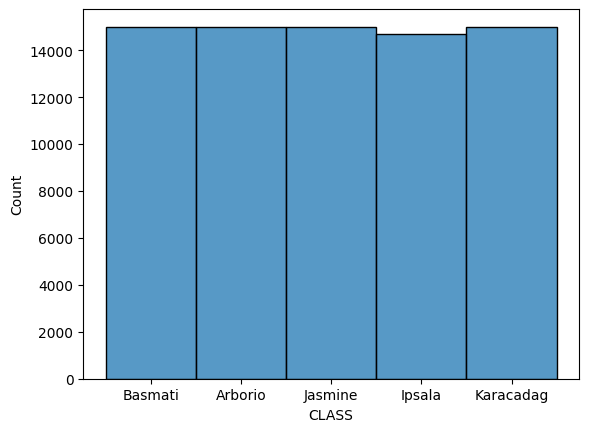

<Figure size 640x480 with 0 Axes>

In [16]:
#Target col info
fg = plt.figure()
sns.histplot(data=df, x=target_column)
plt.savefig(f"{figure_folder}histograms/hist-{target_column}.png")
plt.show()
plt.close(fg)
plt.cla()
plt.clf()

### Correlation heatmap

In [17]:
fg = plt.figure(figsize=(50,50))
sns.heatmap(data=df.corr())
plt.savefig(f"{figure_folder}corr-heatmap.png", bbox_inches = 'tight', dpi=400)
plt.close(fg)
plt.cla()
plt.clf()

<Figure size 640x480 with 0 Axes>

### Violin plots

In [18]:
for col in numerical_features:
    fg = plt.figure()
    sns.violinplot(data=df, x=target_column, y=col)
    plt.savefig(f"{figure_folder}violins/viol-{col}.png")
    plt.close(fg)
    plt.cla()
    plt.clf()

<Figure size 640x480 with 0 Axes>

## Detect outliers

In [19]:
import OutlierDetection as out_det

In [20]:
outlierCounts = {}
for col in numerical_features:
    outliersIQR = out_det.indicies_of_outliers(df[col])
    outliersZScore = out_det.outliers_z_score(df[col])
    outliersModZScore = out_det.outliers_modified_z_score(df[col])
    outlierCounts[col] = { "IQR": outliersIQR, "ZScore": outliersZScore, "ModZScore": outliersModZScore }

### Visualize the outliers

In [21]:
outlier_df = pd.DataFrame.from_dict(outlierCounts, orient = "index")
outlier_count_df = outlier_df.applymap(lambda x: len(x))

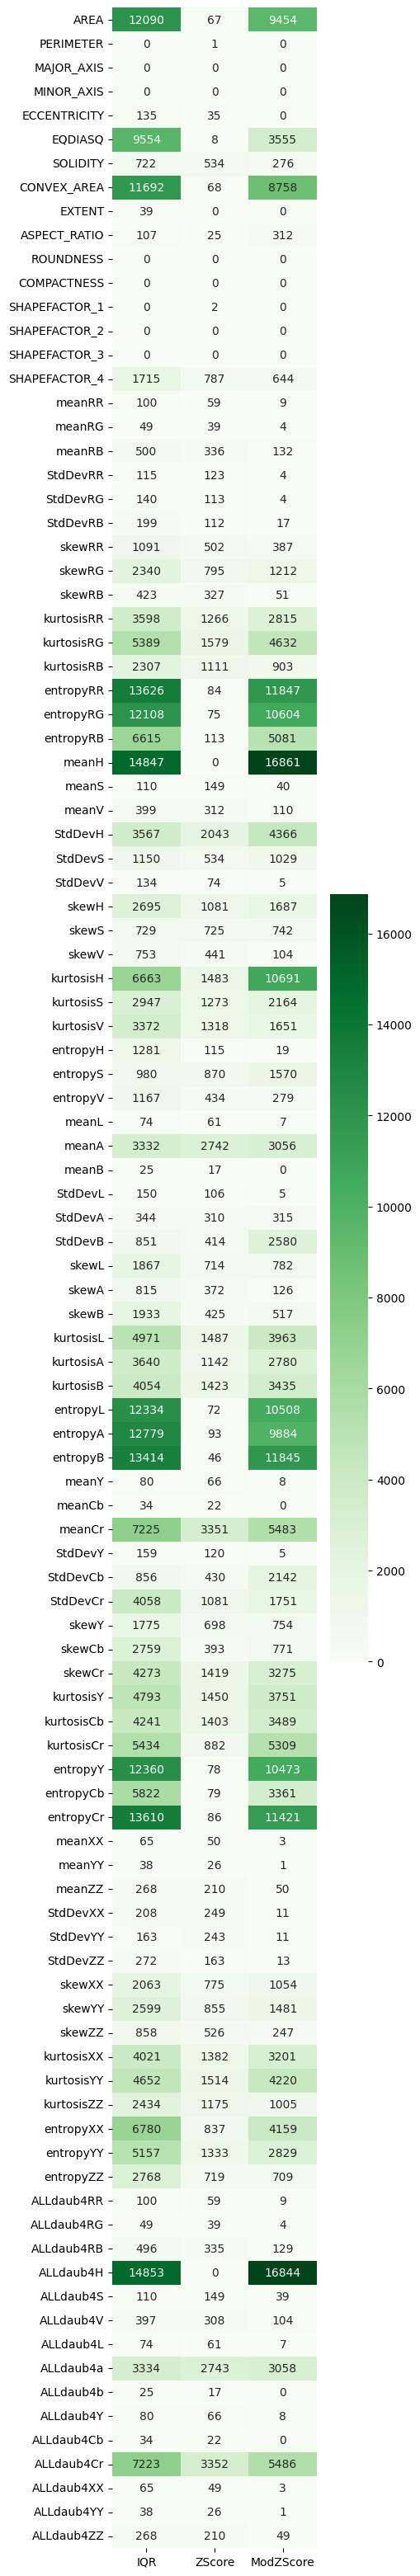

<Figure size 640x480 with 0 Axes>

In [22]:
fg = plt.figure(figsize=(4,40))
sns.heatmap(data=outlier_count_df, annot=True, fmt="d", cmap="Greens")
plt.savefig(f"{figure_folder}outlier-heatmap.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fg)
plt.cla()
plt.clf()

# Preprocessing

## Encoding the target variable

In [23]:
target_column_dict = { "Basmati": 0, "Arborio": 1, "Jasmine": 2, "Ipsala": 3, "Karacadag": 4 }
reverse_target_column_dict = { 0: "Basmati", 1: "Arborio", 2: "Jasmine", 3: "Ipsala", 4: "Karacadag" }
df[target_column] = df[target_column].replace(target_column_dict)

## Scaling

Considering the high number of outliers across features (up to 20%), and the indication that they are important for predicting the target variable, we won't remove them, but try to balance them out through scaling.

### Define scaling functions

In [24]:
import sklearn.preprocessing as preproc

In [25]:
#Define scaling functions
def minmax_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    scaler = preproc.MinMaxScaler(feature_range=(0, 1))
    df[columns_toscale] = scaler.fit_transform(df[columns_toscale])
    return df               
         
def standard_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    std_scaler = preproc.StandardScaler()
    df[columns_toscale] = std_scaler.fit_transform(df[columns_toscale])
    return df
    
def robust_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    rbst_scaler = preproc.RobustScaler()
    df[columns_toscale] = rbst_scaler.fit_transform(df[columns_toscale])
    return df

def quantile_scale(dataframe: pd.DataFrame, columns_toscale: list, distribution: str):
    df = dataframe.copy()
    quantile_transformer = preproc.QuantileTransformer(random_state=0, output_distribution=distribution)
    df[columns_toscale] = quantile_transformer.fit_transform(df[columns_toscale])
    return df

def power_scale(dataframe: pd.DataFrame, columns_toscale: list):
    df = dataframe.copy()
    power_transformer = preproc.PowerTransformer()
    df[columns_toscale] = power_transformer.fit_transform(df[columns_toscale])
    return df

In [26]:
dfs_touse = {}

In [61]:
dfs_touse["MinMax"] = minmax_scale(df, numerical_features) 
dfs_touse["Standard"] = standard_scale(df, numerical_features)
dfs_touse["Robust"] = robust_scale(df, numerical_features) 
dfs_touse["Quantile (Uniform)"] = quantile_scale(df, numerical_features, "uniform") 
dfs_touse["Quantile (Normal)"] = quantile_scale(df, numerical_features, "normal") 
dfs_touse["Power"] = power_scale(df, numerical_features)
dfs_touse["Raw"] = df

# Testing

In [28]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
import time
from keras.utils import np_utils
import signal
import multiprocessing

In [29]:
num_workers = 6

#Init parallelization assets
def init_worker():
    ''' Add KeyboardInterrupt exception to mutliprocessing workers '''
    signal.signal(signal.SIGINT, signal.SIG_IGN)

def getMultiProcPool():
    return multiprocessing.Pool(num_workers, init_worker)

#### Define reference test

In [30]:
scoring_metrics = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1_score': make_scorer(f1_score, average='weighted')
    }

def reference_test(model, data, label, printRes = False):
    starttime = time.perf_counter()
    cv_results = cross_validate(model, data.drop(columns=[target_column]), data[target_column], scoring=scoring_metrics,
         cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=1), n_jobs=-1, return_estimator=True, error_score='raise')
    endtime = time.perf_counter()
    
    AccuScores = cv_results['test_accuracy']
    PrecScores = cv_results['test_precision']
    RecScores = cv_results['test_recall']
    F1Scores = cv_results['test_f1_score']

    AccuScores = np.absolute(AccuScores)
    PrecScores = np.absolute(PrecScores)
    RecScores = np.absolute(RecScores)
    F1Scores = np.absolute(F1Scores)

    print(f"{label} - time to cross validate: {endtime - starttime:0.4f}s", flush=True)
    
    # summarize the model performance
    if (printRes == True):
        print(f'{label} - scoring results:', flush=True)
        print('Accuracy: {:.3%}'.format(np.mean(AccuScores)), flush=True)
        print('Precision: {:.3%}'.format(np.mean(PrecScores)), flush=True)
        print('Recall: {:.3%}'.format(np.mean(RecScores)), flush=True)
        print('F1 Score: {:.3%}'.format(np.mean(F1Scores)), flush=True)
        
    return {
        'Accuracy': np.mean(AccuScores),
        'Precision': np.mean(PrecScores),
        'Recall': np.mean(RecScores),
        'F1': np.mean(F1Scores),
        'Accuracy - std': np.std(AccuScores),
        'Precision - std': np.std(PrecScores),
        'Recall - std': np.std(RecScores),
        'F1 - std': np.std(F1Scores)
    }

#### Define basic network test

In [32]:
def test_network(network, X_train, X_test, X_val, Y_val, Y_train, Y_test, class_map, label, batch_size, epochs, callbacks=None):
    Y_train_enc = np_utils.to_categorical(Y_train, num_classes=5)
    Y_test_enc = np_utils.to_categorical(Y_test, num_classes=5)
    Y_val_enc = np_utils.to_categorical(Y_val, num_classes=5)
    
    starttime = time.perf_counter()
    history = network.fit(X_train, Y_train_enc,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=callbacks,
          validation_data = (X_val, Y_val_enc),
          verbose=0)
    traintime = time.perf_counter() - starttime

    starttime = time.perf_counter()
    Y_pred = np.argmax(network.predict(X_test), axis=-1)
    result = classification_report(Y_test, Y_pred, output_dict=True)
    scores = network.evaluate(X_test, Y_test_enc, verbose=0)
    testtime = time.perf_counter() - starttime
    
    print(f"{label}:")
    print(f"\tTime to train: {traintime:0.4f}s")
    print(f"\tTime to test: {testtime:0.4f}s", flush = True)

    return {
        'Accuracy': scores[1],
        f'Precision_{class_map[0]}': result['0']['precision'],
        f'Precision_{class_map[1]}': result['1']['precision'],
        f'Precision_{class_map[2]}': result['2']['precision'],
        f'Precision_{class_map[3]}': result['3']['precision'],
        f'Precision_{class_map[4]}': result['4']['precision'],
        'Precision_avg': result['weighted avg']['precision'],
        'Precision_std': np.std([result['0']['precision'],result['1']['precision'],result['2']['precision'],result['3']['precision'],result['4']['precision']]),
        f'Recall_{class_map[0]}': result['0']['recall'],
        f'Recall_{class_map[1]}': result['1']['recall'],
        f'Recall_{class_map[2]}': result['2']['recall'],
        f'Recall_{class_map[3]}': result['3']['recall'],
        f'Recall_{class_map[4]}': result['4']['recall'],
        'Recall_avg': result['weighted avg']['recall'],
        'Recall_std': np.std([result['0']['recall'],result['1']['recall'],result['2']['recall'],result['3']['recall'],result['4']['recall']]),
        f'F1_{class_map[0]}': result['0']['f1-score'],
        f'F1_{class_map[1]}': result['1']['f1-score'],
        f'F1_{class_map[2]}': result['2']['f1-score'],
        f'F1_{class_map[3]}': result['3']['f1-score'],
        f'F1_{class_map[4]}': result['4']['f1-score'],
        'F1_avg': result['weighted avg']['f1-score'],
        'F1_std': np.std([result['0']['f1-score'],result['1']['f1-score'],result['2']['f1-score'],result['3']['f1-score'],result['4']['f1-score']])
    }, history

#### Define extensive network test

In [33]:
def cv_test_network(build_network, data, class_map, label, batch_size, epochs, callbacks=None):
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    accuracy = 0
    precision_0 = 0
    precision_1 = 0
    precision_2 = 0
    precision_3 = 0
    precision_4 = 0
    precision_avg = 0
    recall_0 = 0
    recall_1 = 0
    recall_2 = 0
    recall_3 = 0
    recall_4 = 0
    recall_avg = 0
    f1_0 = 0
    f1_1 = 0
    f1_2 = 0
    f1_3 = 0
    f1_4 = 0
    f1_avg = 0
    
    fold_no = 0
    for train_indices, test_indices in cv.split(X, Y):
        X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
        Y_train, Y_test = Y.iloc[train_indices], Y.iloc[test_indices]
        
        Y_train_enc = np_utils.to_categorical(Y_train, num_classes=5)
        Y_test_enc = np_utils.to_categorical(Y_test, num_classes=5)
        
        network = build_network()
        
        starttime = time.perf_counter()
        network.fit(X_train, Y_train_enc,
              batch_size=batch_size,
              epochs=epochs,
              callbacks=callbacks,
              verbose=0)
        endttime = time.perf_counter()
        
        print(f"{label} (fold number {fold_no}) - time to train: {endttime - starttime:0.4f}s")
        
        Y_pred = np.argmax(network.predict(X_test), axis=-1)
        
        result = classification_report(Y_test, Y_pred, output_dict=True)
        scores = network.evaluate(X_test, Y_test_enc, verbose=0)
        
        accuracy += scores[1]
        precision_0 += result['0']['precision']
        precision_1 += result['1']['precision']
        precision_2 += result['2']['precision']
        precision_3 += result['3']['precision']
        precision_4 += result['4']['precision']
        precision_avg += result['weighted avg']['precision']
        recall_0 += result['0']['recall']
        recall_1 += result['1']['recall']
        recall_2 += result['2']['recall']
        recall_3 += result['3']['recall']
        recall_4 += result['4']['recall']
        recall_avg += result['weighted avg']['recall']
        f1_0 += result['0']['f1-score']
        f1_1 += result['1']['f1-score']
        f1_2 += result['2']['f1-score']
        f1_3 += result['3']['f1-score']
        f1_4 += result['4']['f1-score']
        f1_avg += result['weighted avg']['f1-score']
        
        fold_no += 1
        
    accuracy /= fold_no
    precision_0 /= fold_no
    precision_1 /= fold_no
    precision_2 /= fold_no
    precision_3 /= fold_no
    precision_4 /= fold_no
    precision_avg /= fold_no
    recall_0 /= fold_no
    recall_1 /= fold_no
    recall_2 /= fold_no
    recall_3 /= fold_no
    recall_4 /= fold_no
    recall_avg /= fold_no
    f1_0 /= fold_no
    f1_1 /= fold_no
    f1_2 /= fold_no
    f1_3 /= fold_no
    f1_4 /= fold_no
    f1_avg /= fold_no
    
    return {
        'Accuracy': accuracy,
        f'Precision_{class_map[0]}': precision_0,
        f'Precision_{class_map[1]}': precision_1,
        f'Precision_{class_map[2]}': precision_2,
        f'Precision_{class_map[3]}': precision_3,
        f'Precision_{class_map[4]}': precision_4,
        'Precision_avg': precision_avg,
        f'Recall_{class_map[0]}': recall_0,
        f'Recall_{class_map[1]}': recall_1,
        f'Recall_{class_map[2]}': recall_2,
        f'Recall_{class_map[3]}': recall_3,
        f'Recall_{class_map[4]}': recall_4,
        'Recall_avg': recall_avg,
        f'F1_{class_map[0]}': f1_0,
        f'F1_{class_map[1]}': f1_1,
        f'F1_{class_map[2]}': f1_2,
        f'F1_{class_map[3]}': f1_3,
        f'F1_{class_map[4]}': f1_4,
        'F1_avg': f1_avg
    }


## Different scaling methods

We will define a simple neural network to test different scaling methods, before proceeding with more detailed testing.

### Define basic neural network

In [34]:
def build_basic_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation='relu'))
    network.add(Dense(80, activation='relu'))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

### Perform reference tests

In [35]:
from sklearn.tree import DecisionTreeClassifier

reference_results = {}
decision_tree = DecisionTreeClassifier()

In [36]:
#Helper method
def perform_ref_test(model, label, repetition=1):
    global reference_results

    #Perform first repetition
    reference_results[label] = reference_test(model, dfs_touse[label], label + "1")

    #Perform the rest of the repetions and calculate a rolling mean
    for i in range(2, repetition + 1):
        local_results = reference_test(model, dfs_touse[label], label + str(i))

        for key, value in local_results.items():
            reference_results[label][key] = np.mean([value, reference_results[label][key]])

In [37]:
print('Performing reference tests with a DecisionTree classifier...')

perform_ref_test(decision_tree, 'MinMax', 10)
perform_ref_test(decision_tree, 'Standard', 10)
perform_ref_test(decision_tree, 'Robust', 10)
perform_ref_test(decision_tree, 'Quantile (Uniform)', 10)
perform_ref_test(decision_tree, 'Quantile (Normal)', 10)
perform_ref_test(decision_tree, 'Power', 10)
perform_ref_test(decision_tree, 'Raw', 10)

Performing reference tests with a DecisionTree classifier...
MinMax1 - time to cross validate: 10.0156s
MinMax2 - time to cross validate: 9.2783s
MinMax3 - time to cross validate: 8.6503s
MinMax4 - time to cross validate: 8.6217s
MinMax5 - time to cross validate: 8.5637s
MinMax6 - time to cross validate: 8.7174s
MinMax7 - time to cross validate: 8.1534s
MinMax8 - time to cross validate: 8.4859s
MinMax9 - time to cross validate: 8.1747s
MinMax10 - time to cross validate: 8.2903s
Standard1 - time to cross validate: 8.1604s
Standard2 - time to cross validate: 8.3931s
Standard3 - time to cross validate: 8.4530s
Standard4 - time to cross validate: 8.3241s
Standard5 - time to cross validate: 8.3602s
Standard6 - time to cross validate: 8.3085s
Standard7 - time to cross validate: 8.3082s
Standard8 - time to cross validate: 8.1665s
Standard9 - time to cross validate: 8.5505s
Standard10 - time to cross validate: 8.4150s
Robust1 - time to cross validate: 8.2378s
Robust2 - time to cross validate: 

In [64]:
#Compile results
reference_df = pd.DataFrame.from_dict(reference_results, orient='index')

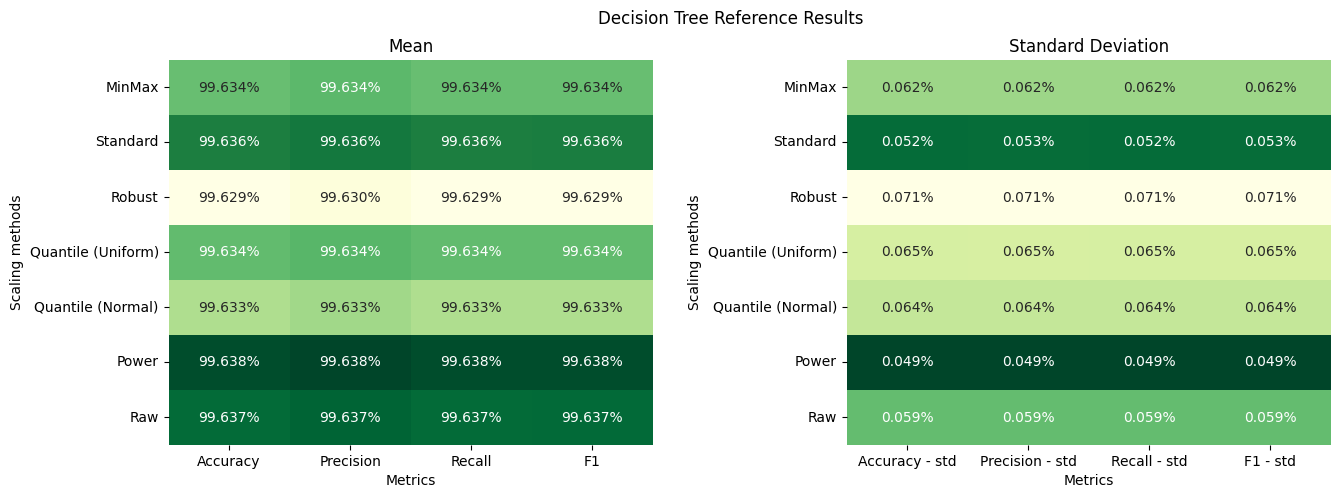

<Figure size 640x480 with 0 Axes>

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Decision Tree Reference Results')

acc_reference_df = reference_df[['Accuracy', 'Precision', 'Recall', 'F1']]
sns.heatmap(acc_reference_df, annot=acc_reference_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Scaling methods")

std_reference_df = reference_df[['Accuracy - std', 'Precision - std', 'Recall - std', 'F1 - std']]
sns.heatmap(std_reference_df, annot=std_reference_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}reference-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

### Perform network tests

In [40]:
from sklearn.model_selection import train_test_split

network_results = {}

In [41]:
def perform_net_test(build_network, label, batch_size, epochs, callbacks = None):
    data = dfs_touse[label]
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    #Perform first repetition
    res, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label, batch_size, epochs, callbacks = callbacks)
    global network_results
    network_results[label] = res  

    return history

def perform_rep_net_test(build_network, label, batch_size, epochs, repetitions = 1, callbacks = None):
    data = dfs_touse[label]
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    #Perform first repetition
    res, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label + "1", batch_size, epochs, callbacks = callbacks)
    global network_results
    network_results[label] = res  

    histories = {}
    histories[1] = history

    #Perform the rest of the repetions and calculate a rolling mean
    for i in range(2, repetitions + 1):
        local_results, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label + str(i), batch_size, epochs, callbacks = callbacks)
        histories[i] = history

        for key, value in local_results.items():
            network_results[label][key] = np.mean([value, network_results[label][key]])

    return histories, label

In [88]:
print("Performing basic network testing over different scaling methods...")
perform_rep_net_test(build_basic_network, 'MinMax', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Standard', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Robust', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Quantile (Uniform)', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Quantile (Normal)', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Power', 100, 3, 10)
perform_rep_net_test(build_basic_network, 'Raw', 100, 3, 10)

Performing basic network testing over different scaling methods...
701/701 [==============================] - 0s 333us/step
MinMax1:
	Time to train: 21.6446s
	Time to test: 18.3297s
701/701 [==============================] - 0s 364us/step
MinMax2:
	Time to train: 21.5139s
	Time to test: 18.3960s
701/701 [==============================] - 0s 372us/step
MinMax3:
	Time to train: 21.7809s
	Time to test: 18.2464s
701/701 [==============================] - 0s 340us/step
MinMax4:
	Time to train: 21.5565s
	Time to test: 18.2117s
701/701 [==============================] - 0s 359us/step
MinMax5:
	Time to train: 21.7485s
	Time to test: 18.3192s
701/701 [==============================] - 0s 355us/step
MinMax6:
	Time to train: 22.0698s
	Time to test: 19.0007s
701/701 [==============================] - 0s 346us/step
MinMax7:
	Time to train: 22.2437s
	Time to test: 18.4116s
701/701 [==============================] - 0s 332us/step
MinMax8:
	Time to train: 21.2462s
	Time to test: 18.1426s
701/701 [====

c:\Users\DjordjeNikolic\source\repos\RiceMSC-ImageAnalysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DjordjeNikolic\source\repos\RiceMSC-ImageAnalysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\DjordjeNikolic\source\repos\RiceMSC-ImageAnalysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this beh

Raw8:
	Time to train: 33.9816s
	Time to test: 28.7436s
701/701 [==============================] - 0s 320us/step
Raw9:
	Time to train: 34.0711s
	Time to test: 28.8299s
701/701 [==============================] - 0s 333us/step
Raw10:
	Time to train: 33.8055s
	Time to test: 28.8620s


({1: <keras.callbacks.History at 0x1f038a0cac0>,
  2: <keras.callbacks.History at 0x1f03f2968f0>,
  3: <keras.callbacks.History at 0x1efa232c9a0>,
  4: <keras.callbacks.History at 0x1efa22b6ec0>,
  5: <keras.callbacks.History at 0x1ef9dca3c40>,
  6: <keras.callbacks.History at 0x1f0359902e0>,
  7: <keras.callbacks.History at 0x1ef9dcadbd0>,
  8: <keras.callbacks.History at 0x1efacc35000>,
  9: <keras.callbacks.History at 0x1efa03951e0>,
  10: <keras.callbacks.History at 0x1ef9f014ac0>},
 'Raw')

In [96]:
#Compile results
scaling_df = pd.DataFrame.from_dict(network_results, orient='index')

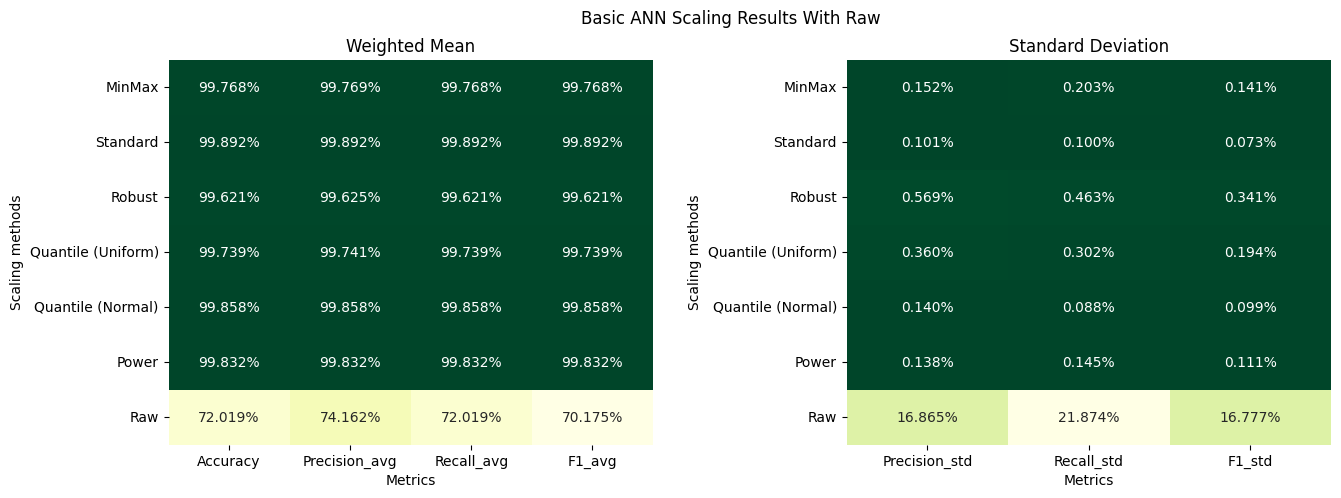

<Figure size 640x480 with 0 Axes>

In [97]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Basic ANN Scaling Results With Raw')

acc_scaling_df = scaling_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_scaling_df, annot=acc_scaling_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Weighted Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Scaling methods")

std_scaling_df = scaling_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_scaling_df, annot=std_scaling_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}scaling-network-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

As we can see, the non processed data set gives us pretty poor performance, so we will remove it from the results to get better information.

In [98]:
scaling_df = scaling_df.drop('Raw')

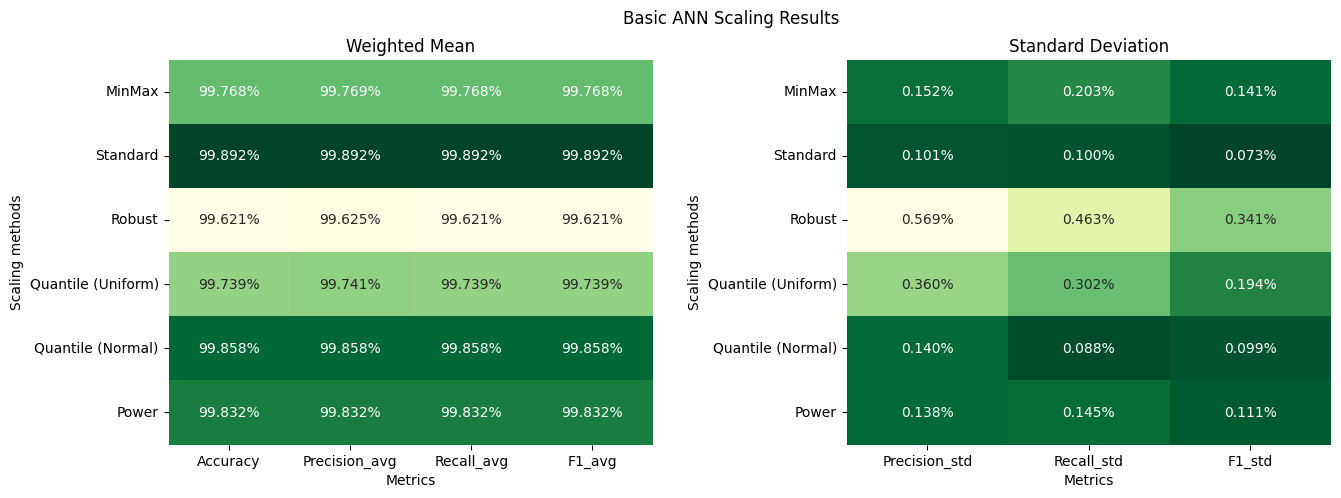

<Figure size 640x480 with 0 Axes>

In [99]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Basic ANN Scaling Results')

acc_scaling_df = scaling_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_scaling_df, annot=acc_scaling_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Weighted Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Scaling methods")

std_scaling_df = scaling_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_scaling_df, annot=std_scaling_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}scaling-network-results-without-raw.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

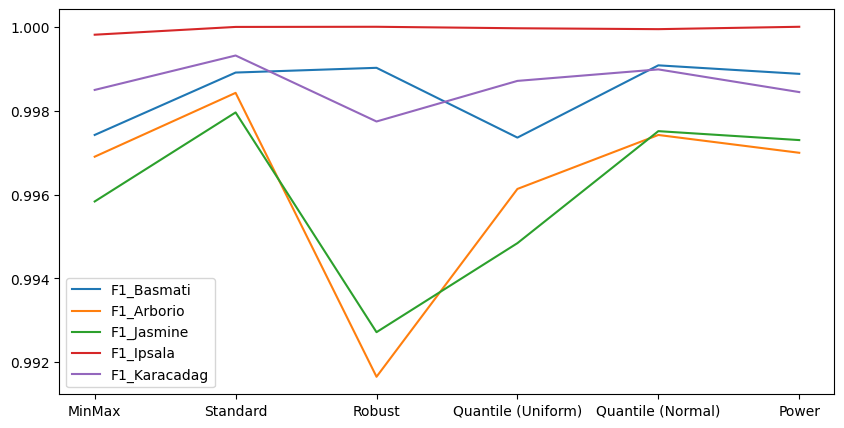

<Figure size 640x480 with 0 Axes>

In [100]:
#Check out F1 scores per classes
f1_scaling_df = scaling_df[['F1_Basmati','F1_Arborio','F1_Jasmine','F1_Ipsala','F1_Karacadag']]

fg = f1_scaling_df.plot(figsize=(10,5))
plt.savefig(f"{figure_folder}scaling-network-results-classes.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close()
plt.cla()
plt.clf()

### Compare results

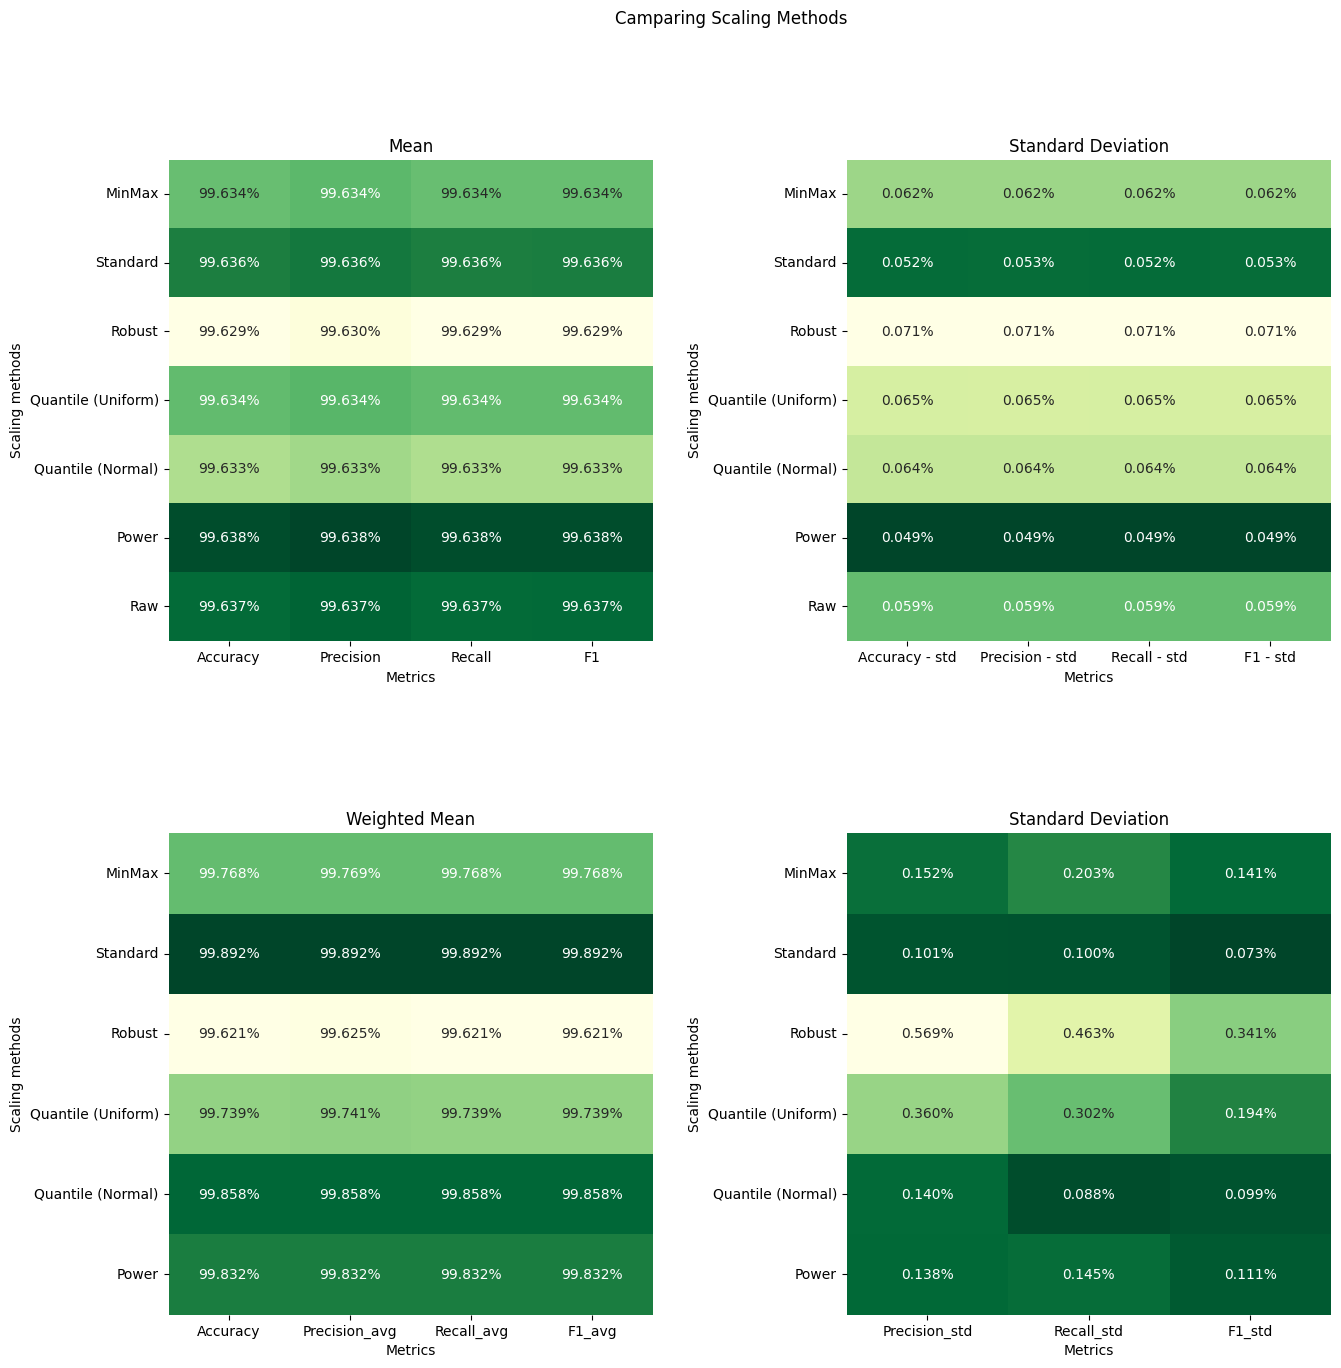

<Figure size 640x480 with 0 Axes>

In [101]:
fig, axes = plt.subplots(2, 2, figsize=(15,15))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Camparing Scaling Methods')

acc_reference_df = reference_df[['Accuracy', 'Precision', 'Recall', 'F1']]
sns.heatmap(acc_reference_df, annot=acc_reference_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0][0])
axes[0][0].set_title("Mean")
axes[0][0].set_xlabel("Metrics")
axes[0][0].set_ylabel("Scaling methods")

std_reference_df = reference_df[['Accuracy - std', 'Precision - std', 'Recall - std', 'F1 - std']]
sns.heatmap(std_reference_df, annot=std_reference_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[0][1])
axes[0][1].set_title("Standard Deviation")
axes[0][1].set_xlabel("Metrics")
axes[0][1].set_ylabel("Scaling methods")

acc_scaling_df = scaling_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_scaling_df, annot=acc_scaling_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[1][0])
axes[1][0].set_title("Weighted Mean")
axes[1][0].set_xlabel("Metrics")
axes[1][0].set_ylabel("Scaling methods")

std_scaling_df = scaling_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_scaling_df, annot=std_scaling_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1][1])
axes[1][1].set_title("Standard Deviation")
axes[1][1].set_xlabel("Metrics")
axes[1][1].set_ylabel("Scaling methods")

plt.savefig(f"{figure_folder}scaling-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

Even though the results are relatively similar betwen the power transformed and the standardized dataset, the dataset that was standardized has better peformance with the basic ANN, so that's the one we will use for further analysis.

# Optimizing the network

In [102]:
optimized_network_results = {}

## Reducing overfitting

In [103]:
def plot_results (history, label):
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(label)
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig(f"{figure_folder}{label}.png", bbox_inches = 'tight', dpi=400)
    plt.show()
    plt.close(fig)
    plt.cla()
    plt.clf()

def perform_opt_net_test(build_network, label, batch_size, epochs, callbacks = None):
    data = dfs_touse[label]
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    #Perform first repetition
    res, history = test_network(build_network(), X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label, batch_size, epochs, callbacks = callbacks)
    global optimized_network_results
    optimized_network_results[label] = res  

    return history

In [104]:
history = perform_opt_net_test(build_basic_network, 'Standard', 1000, 20)

701/701 [==============================] - 0s 357us/step
Standard:
	Time to train: 23.3859s
	Time to test: 18.7669s


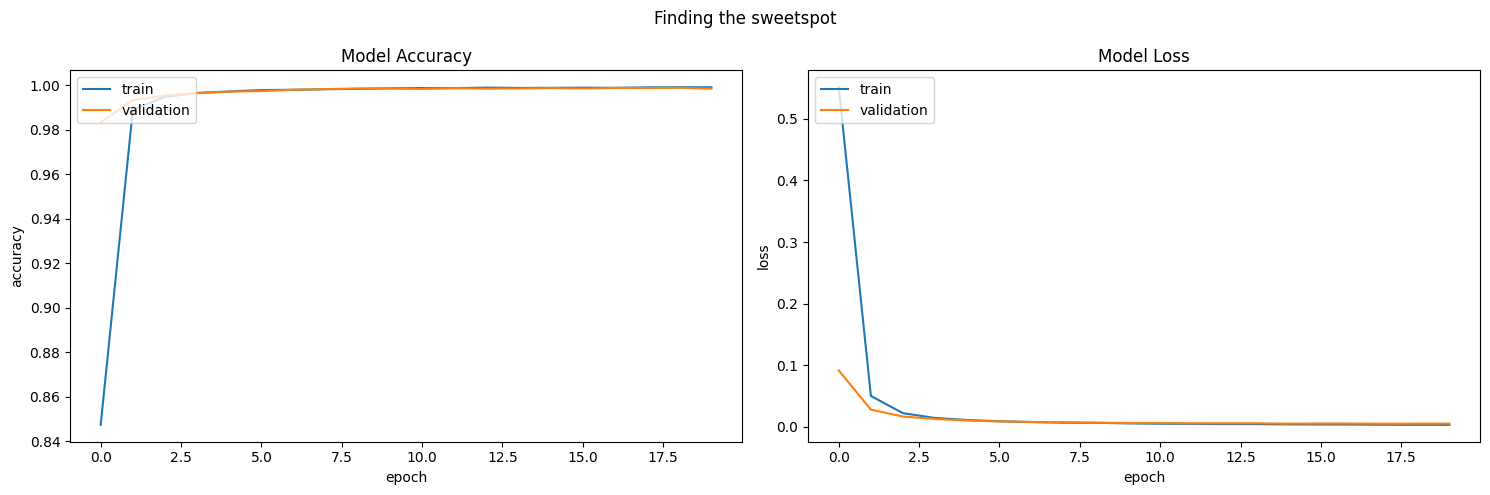

<Figure size 640x480 with 0 Axes>

In [106]:
plot_results(history, "Finding the sweetspot")

Considering our specific situation, where the model's peformance is consistently very good, it's difficult to find the actual point where overfitting starts, but nonetheless, we will attempt multiple traditional methods for combating overfitting, and we will compare the results.

### Weight regularization

In [107]:
#Save previous results
optimized_network_results['Unmodified'] = network_results['Standard']

In [108]:
def build_weighted_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense
    from keras import regularizers

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    network.add(Dense(80, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

In [109]:
history = perform_opt_net_test(build_weighted_network, 'Standard', 1000, 20)

optimized_network_results['Weighted'] = optimized_network_results['Standard']
optimized_network_results['Standard'] = None

701/701 [==============================] - 0s 355us/step
Standard:
	Time to train: 23.7074s
	Time to test: 19.1107s


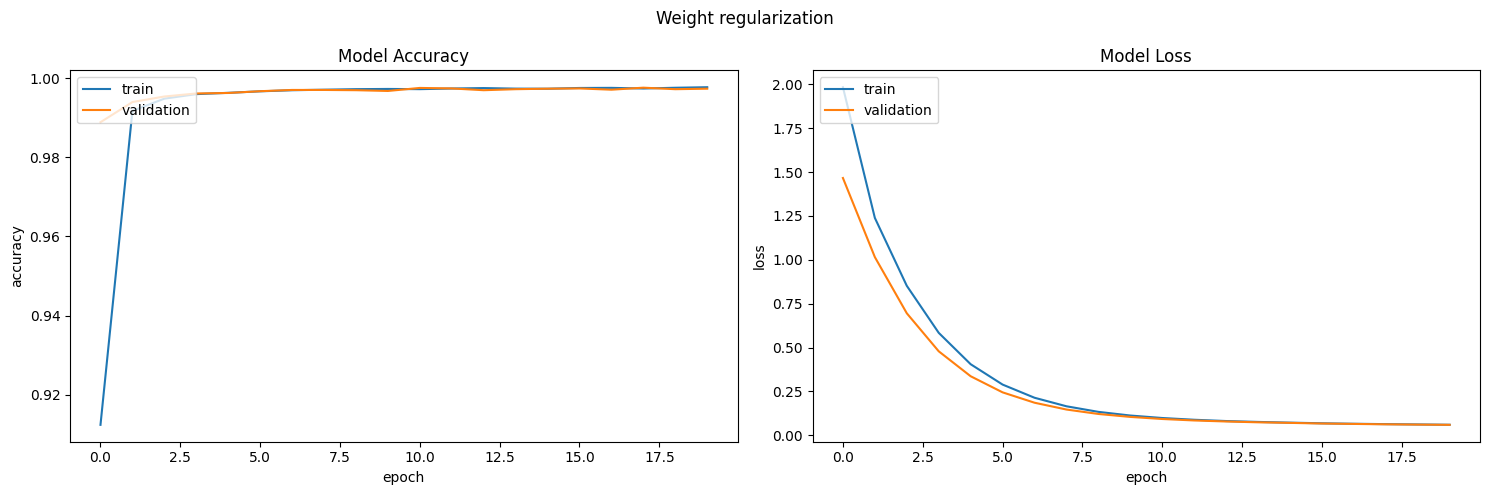

<Figure size 640x480 with 0 Axes>

In [110]:
plot_results(history, "Weight regularization")

### Early stopping

In [111]:
#Prepare callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from tensorflow.keras.models import load_model 

callbacks = [EarlyStopping(monitor="val_loss", patience=2),
             CSVLogger('history.csv'),
             ModelCheckpoint(filepath="best_model.h5",
             monitor="val_loss",
             save_best_only=True)]

In [112]:
history = perform_opt_net_test(build_basic_network, 'Standard', 1000, 20, callbacks=callbacks)

optimized_network_results['EarlyStopping'] = optimized_network_results['Standard']
optimized_network_results['Standard'] = None

701/701 [==============================] - 0s 369us/step
Standard:
	Time to train: 24.0238s
	Time to test: 19.1045s


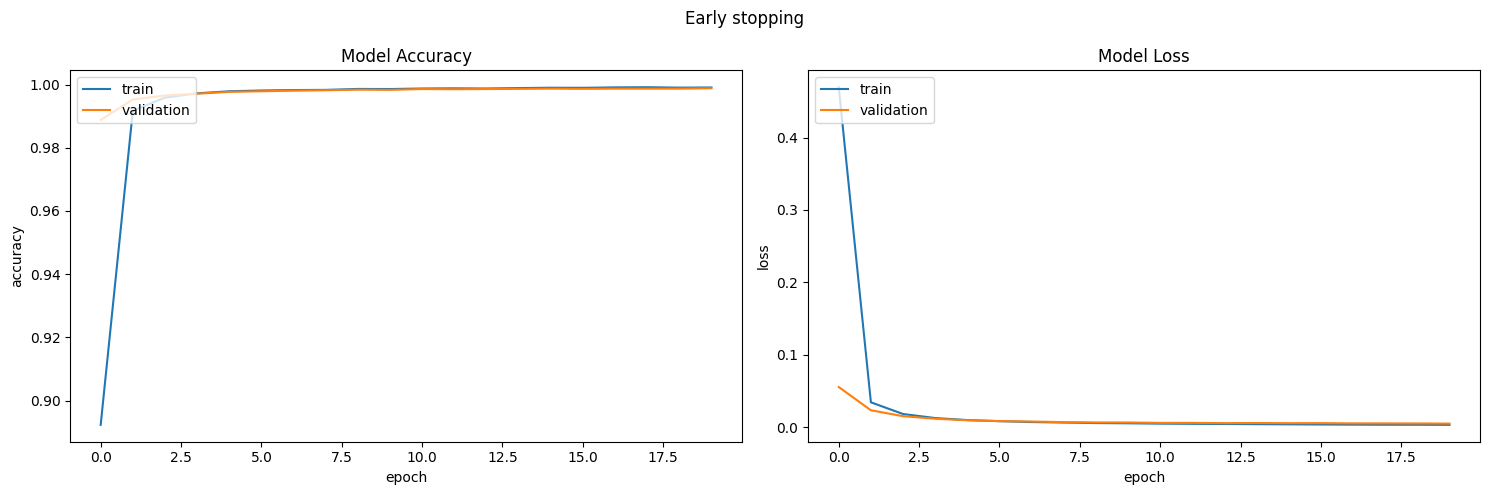

<Figure size 640x480 with 0 Axes>

In [113]:
plot_results(history, "Early stopping")

### Using dropout

In [114]:
def build_dropout_network():
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout

    #Build neural network
    network = Sequential()
    network.add(Dropout(0.2, input_dim=106))
    network.add(Dense(80, activation='relu'))
    network.add(Dropout(0.5))
    network.add(Dense(80, activation='relu'))
    network.add(Dropout(0.5))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    return network

In [115]:
history = perform_opt_net_test(build_dropout_network, 'Standard', 1000, 20)

optimized_network_results['Dropout'] = optimized_network_results['Standard']
optimized_network_results['Standard'] = None

701/701 [==============================] - 0s 334us/step
Standard:
	Time to train: 24.1531s
	Time to test: 18.8085s


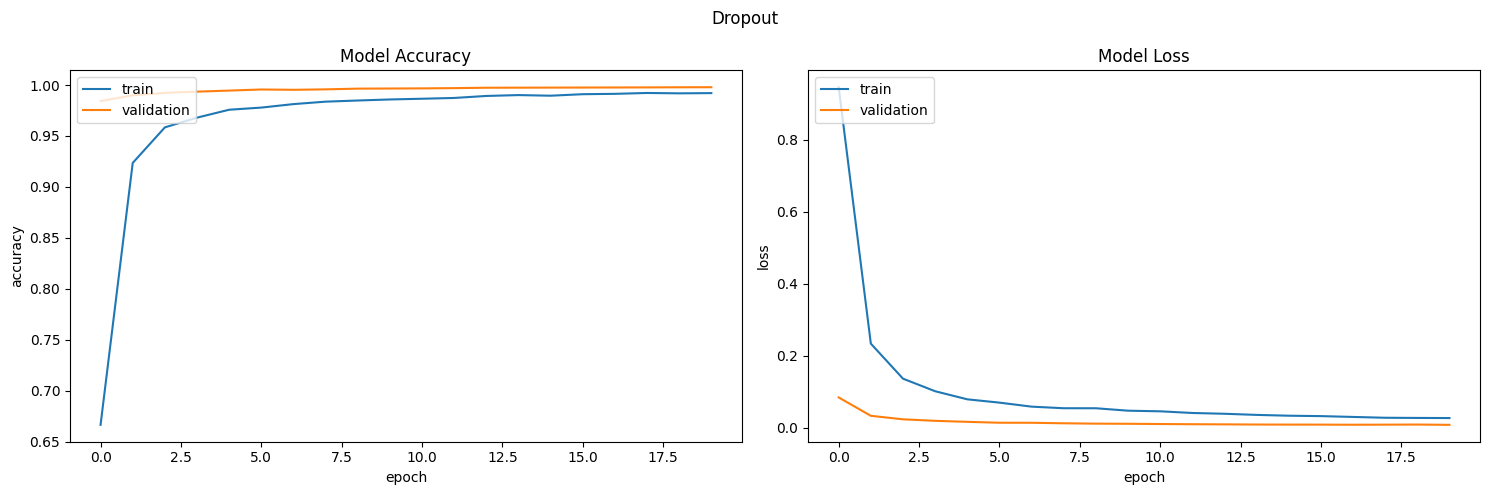

<Figure size 640x480 with 0 Axes>

In [116]:
plot_results(history, "Dropout")

In [127]:
#Compile results
optimized_network_results.pop("Standard")

In [128]:
overfitting_df = pd.DataFrame.from_dict(optimized_network_results, orient='index')

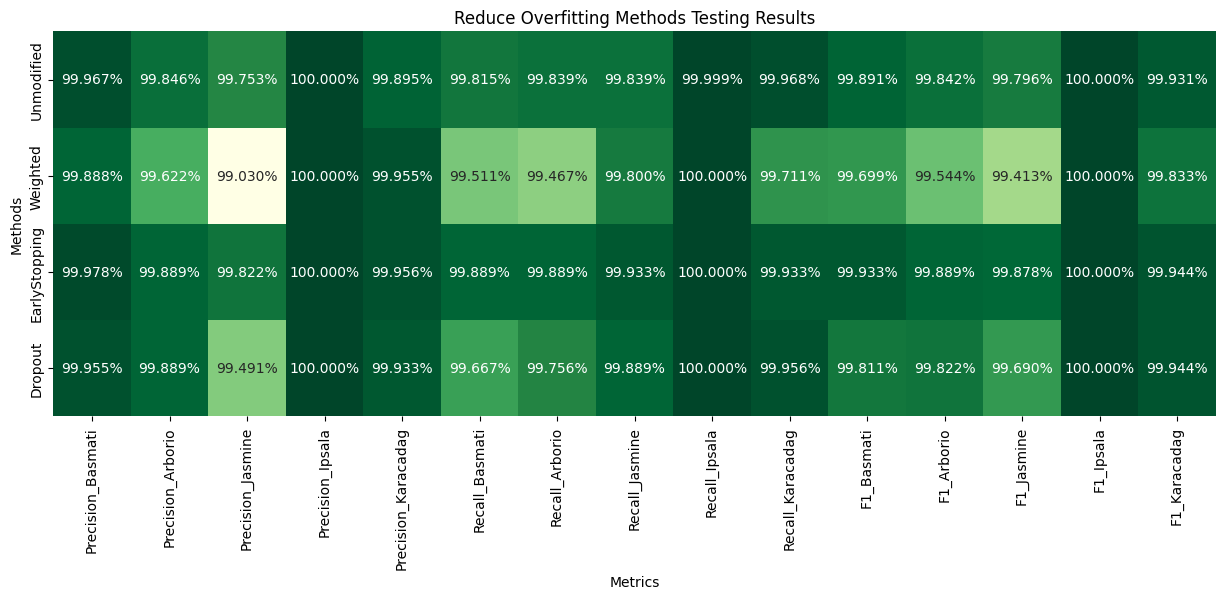

<Figure size 640x480 with 0 Axes>

In [135]:
fig = plt.figure(figsize=(15,5))

class_overfitting_df = overfitting_df.drop(columns=['Accuracy', 'Precision_avg', 'Precision_std', 'Recall_avg', 'Recall_std', 'F1_avg', 'F1_std'])
sns.heatmap(class_overfitting_df, annot=class_overfitting_df, cmap="YlGn", cbar=False, fmt=".3%")
plt.title("Reduce Overfitting Methods Testing Results")
plt.xlabel("Metrics")
plt.ylabel("Methods")
plt.savefig(f"{figure_folder}reduce-overfitting.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

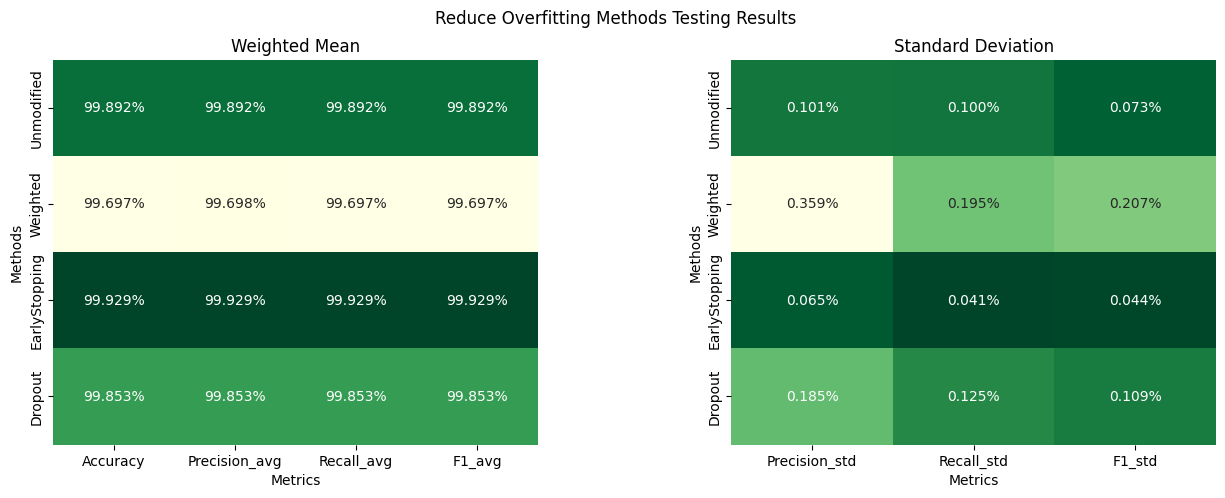

<Figure size 640x480 with 0 Axes>

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Reduce Overfitting Methods Testing Results')

acc_overfitting_df = overfitting_df[['Accuracy', 'Precision_avg', 'Recall_avg', 'F1_avg']]
sns.heatmap(acc_overfitting_df, annot=acc_overfitting_df, cmap="YlGn", cbar=False, fmt=".3%", ax=axes[0])
axes[0].set_title("Weighted Mean")
axes[0].set_xlabel("Metrics")
axes[0].set_ylabel("Methods")

std_overfitting_df = overfitting_df[['Precision_std', 'Recall_std', 'F1_std']]
sns.heatmap(std_overfitting_df, annot=std_overfitting_df, cmap="YlGn_r", cbar=False, fmt=".3%", ax=axes[1])
axes[1].set_title("Standard Deviation")
axes[1].set_xlabel("Metrics")
axes[1].set_ylabel("Methods")

plt.savefig(f"{figure_folder}reduce-overfitting-avg.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

Seemingly, the early stopping technique gives us the best results so we will stick with it.

## Trying out different activation functions

In [136]:
param_results = {}
param_history_results = {}

In [137]:
from tensorflow.keras.layers import PReLU

activation_functions = [
    ('ReLU', 'relu'),
    ('Leaky ReLU', 'leaky_relu'),
    ('Parametric ReLU', PReLU()),
    ('ELU', 'elu'),
    ('GeLU', 'gelu'),
    ('Tanh', 'tanh'),
    ('Sigmoid', 'sigmoid'),
    ('Softmax', 'softmax'),
    ('Softplus', 'softplus'),
    ('Softsign', 'softsign')]

def build_activation_network(activation_function, output_activation='softmax'):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras import regularizers

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation=activation_function))
    network.add(Dense(80, activation=activation_function))
    network.add(Dense(5, activation=output_activation))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    
    return network
    
def perform_param_test(network, data, label, batch_size, epochs, callbacks = None):
    X, Y = data.drop(columns=[target_column]), data[target_column]
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=1, stratify=Y)
    X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.3, random_state=1, stratify=Y_train )
    
    res, history = test_network(network, X_train, X_test, X_val, Y_val, Y_train, Y_test, 
                                          reverse_target_column_dict, label, batch_size, epochs, callbacks = callbacks)
    global param_results
    param_results[label] = res
    
    global param_history_results
    param_history_results[label] = history
    
    return history

701/701 [==============================] - 0s 336us/step
ReLU:
	Time to train: 22.9233s
	Time to test: 18.4032s


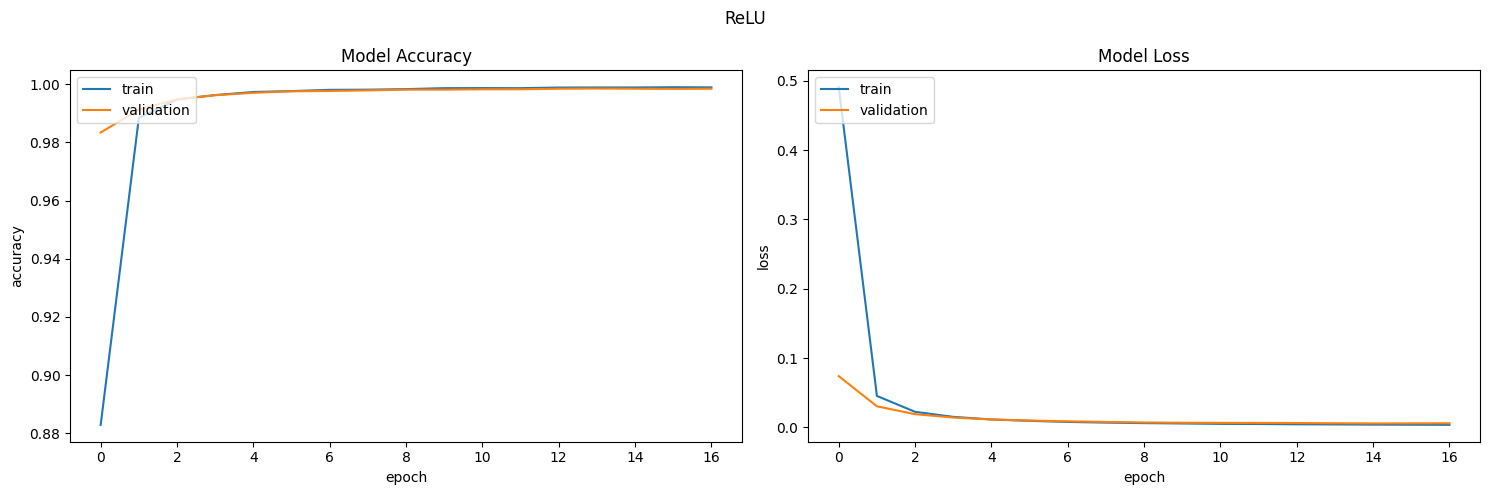

701/701 [==============================] - 0s 338us/step
Leaky ReLU:
	Time to train: 23.5209s
	Time to test: 18.6866s


<Figure size 640x480 with 0 Axes>

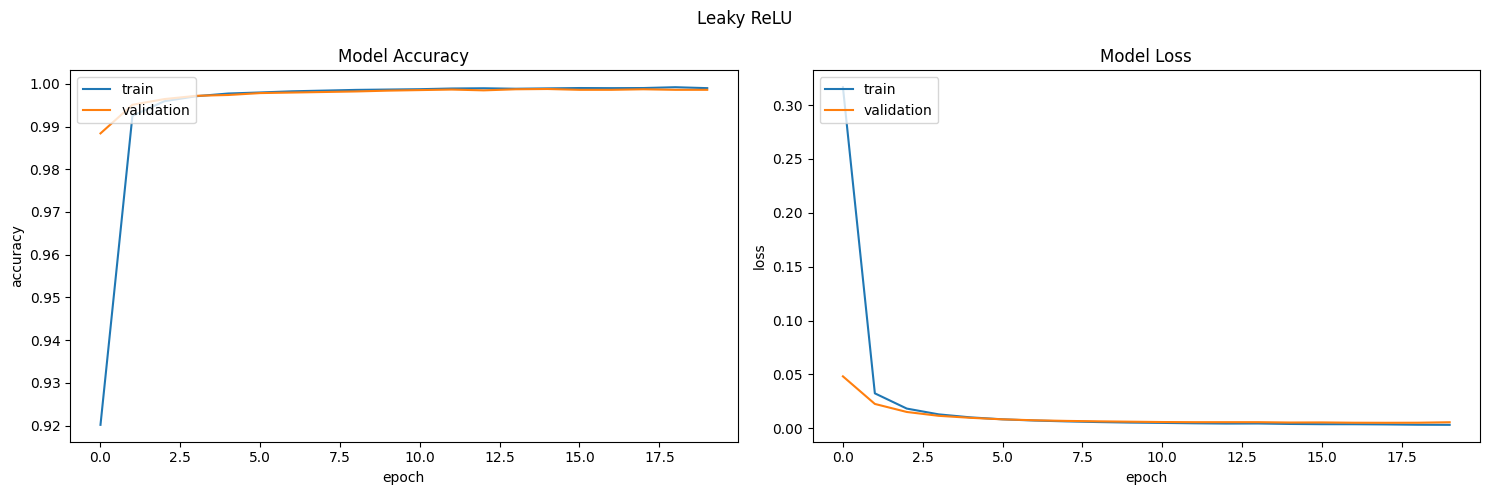

701/701 [==============================] - 0s 335us/step
Parametric ReLU:
	Time to train: 39.9334s
	Time to test: 34.5606s


<Figure size 640x480 with 0 Axes>

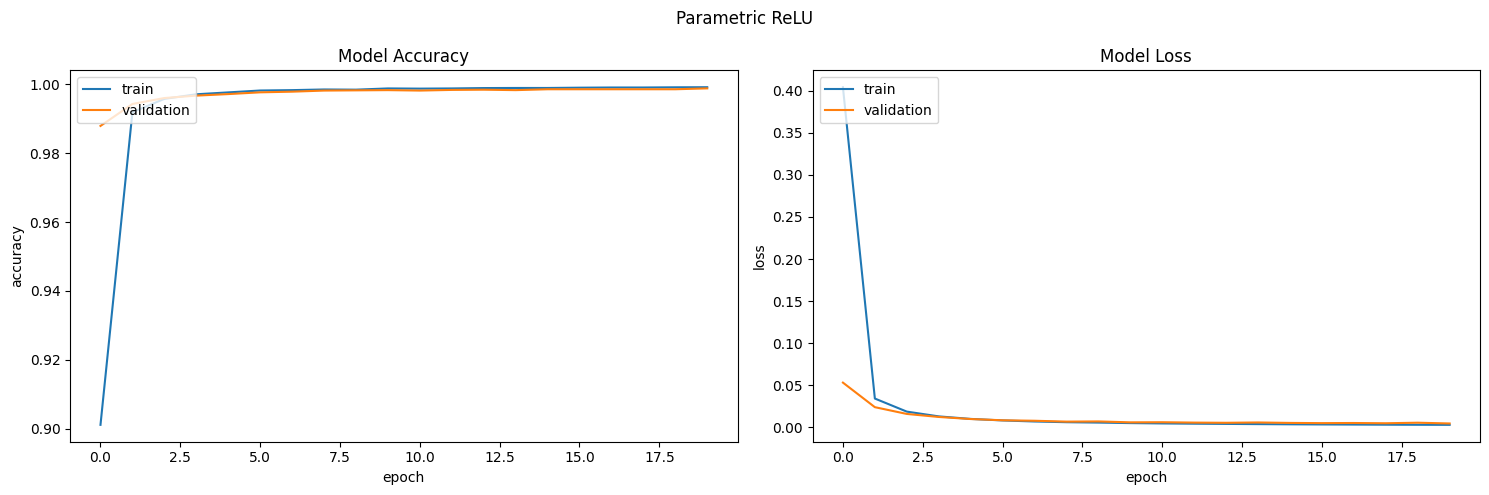

701/701 [==============================] - 0s 341us/step
ELU:
	Time to train: 24.1523s
	Time to test: 19.0676s


<Figure size 640x480 with 0 Axes>

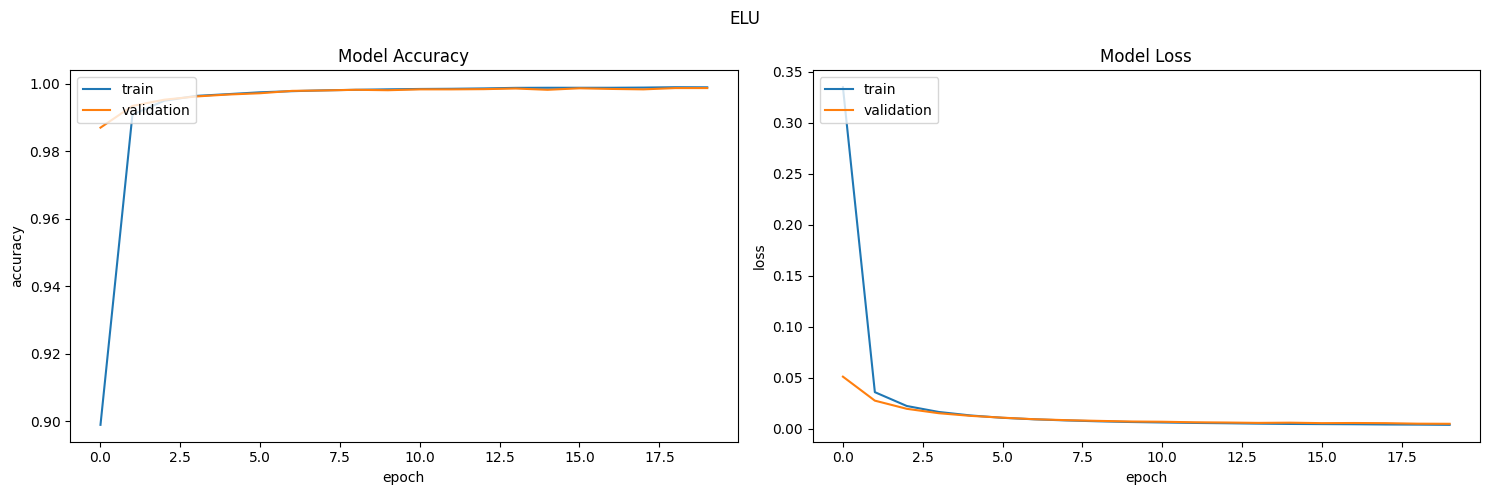

701/701 [==============================] - 0s 346us/step
GeLU:
	Time to train: 24.1311s
	Time to test: 19.2715s


<Figure size 640x480 with 0 Axes>

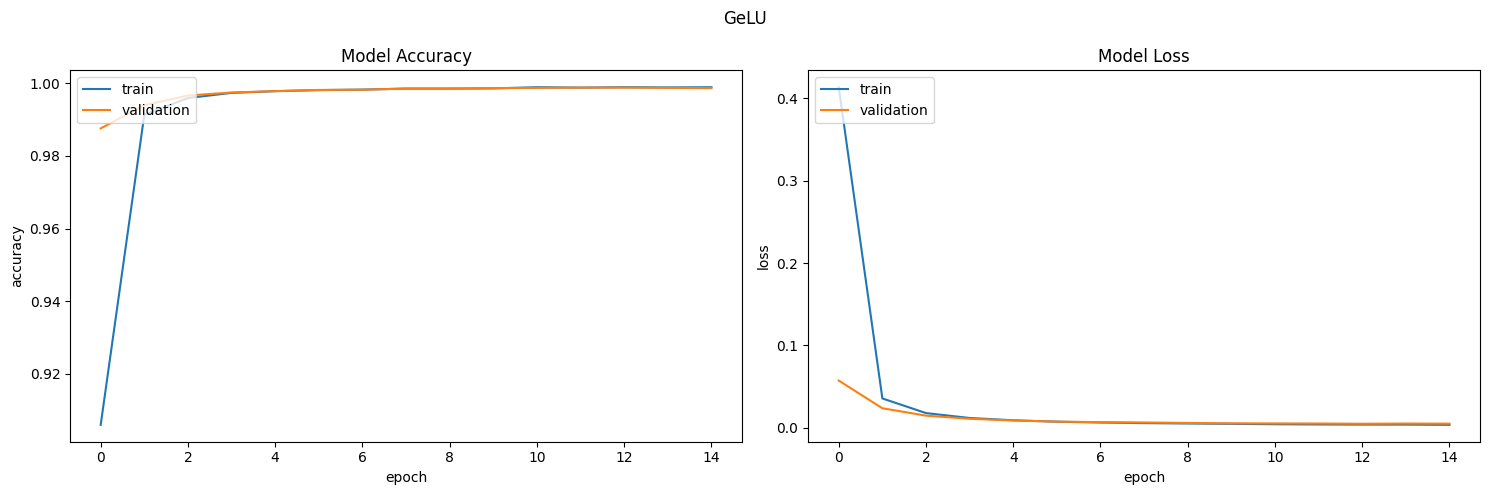

701/701 [==============================] - 0s 376us/step
Tanh:
	Time to train: 23.7651s
	Time to test: 19.4990s


<Figure size 640x480 with 0 Axes>

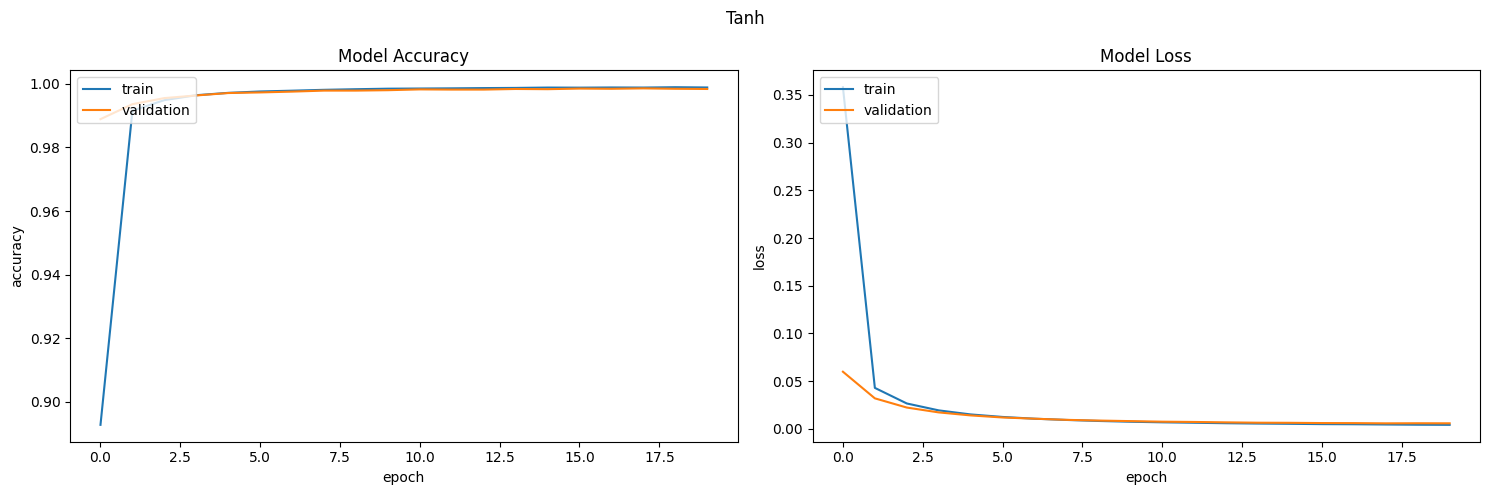

701/701 [==============================] - 0s 348us/step
Sigmoid:
	Time to train: 24.1443s
	Time to test: 19.2949s


<Figure size 640x480 with 0 Axes>

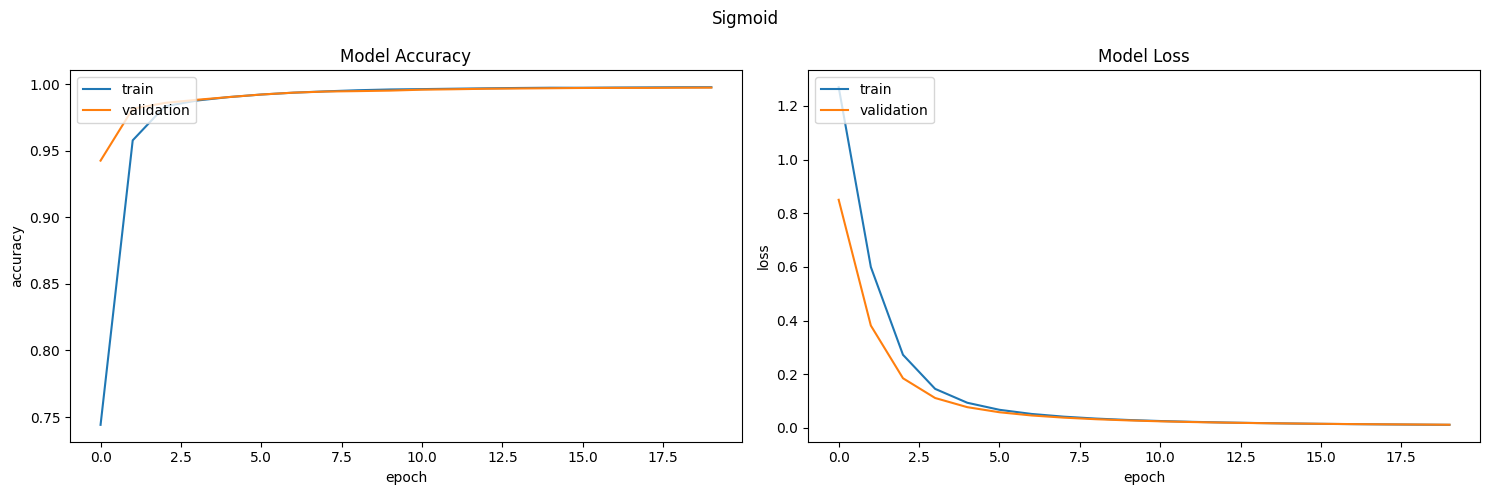

701/701 [==============================] - 0s 358us/step
Softmax:
	Time to train: 24.8529s
	Time to test: 19.6546s


<Figure size 640x480 with 0 Axes>

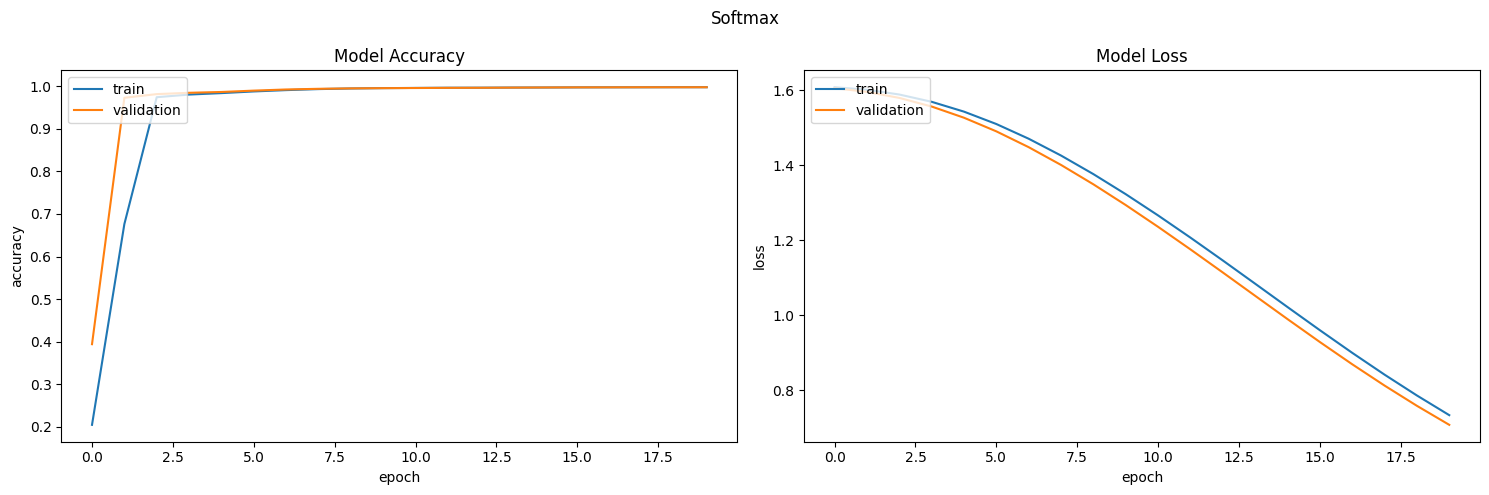

701/701 [==============================] - 0s 395us/step
Softplus:
	Time to train: 23.6706s
	Time to test: 19.4638s


<Figure size 640x480 with 0 Axes>

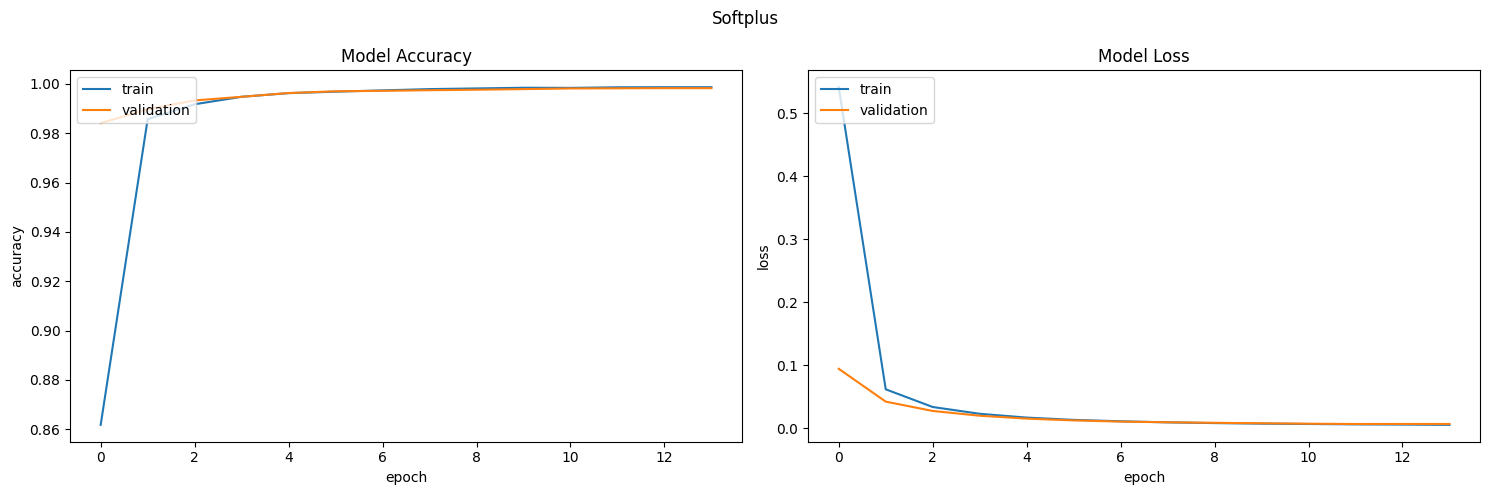

701/701 [==============================] - 0s 350us/step
Softsign:
	Time to train: 24.1238s
	Time to test: 19.1774s


<Figure size 640x480 with 0 Axes>

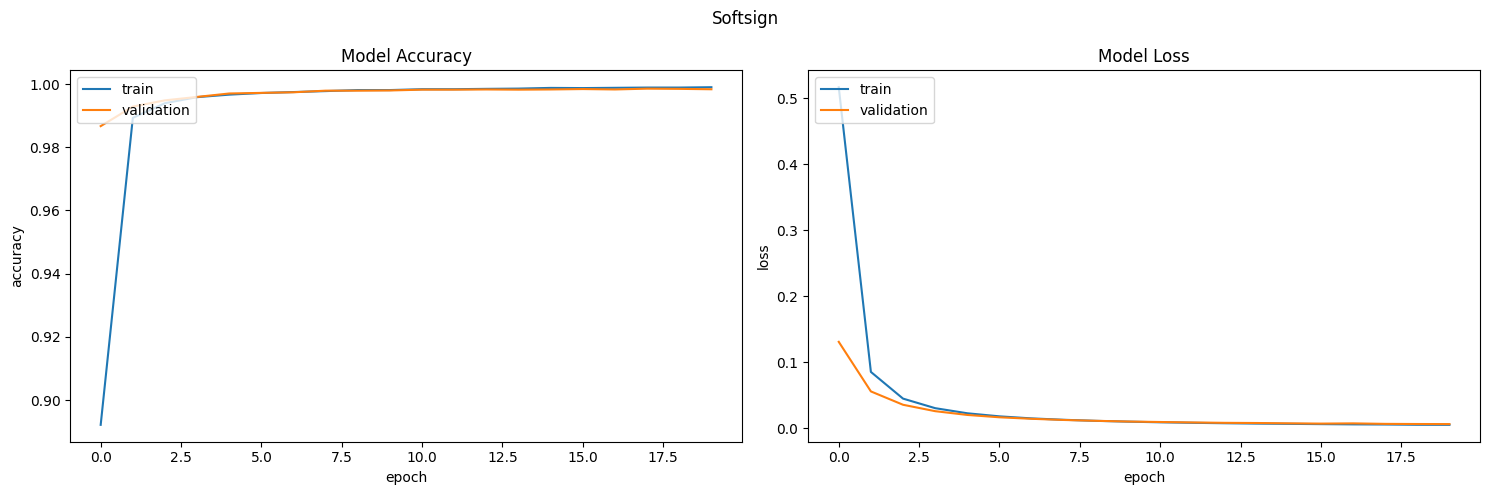

<Figure size 640x480 with 0 Axes>

In [138]:
#Test out all of these activation functions
for label, fun in activation_functions:
    network = build_activation_network(fun)
    history = perform_param_test(network, dfs_touse['Standard'], label, 1000, 20, callbacks=callbacks)
    plot_results(history, label)

701/701 [==============================] - 0s 347us/step
ReLU (Sigmoid):
	Time to train: 23.9794s
	Time to test: 19.1088s


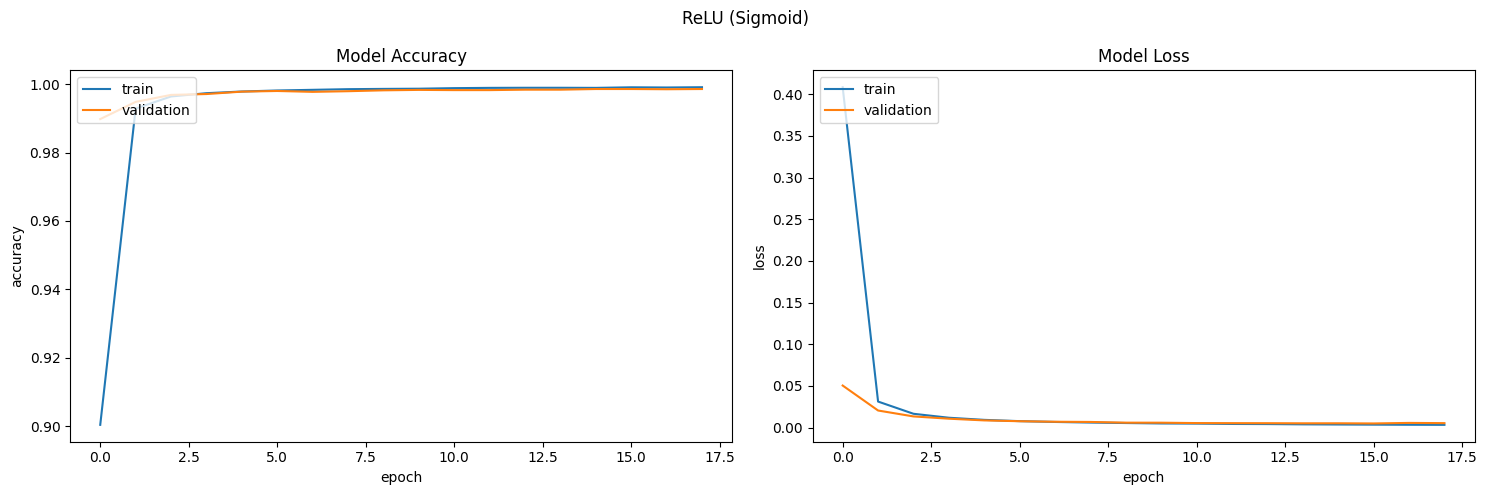

701/701 [==============================] - 0s 582us/step
Leaky ReLU (Sigmoid):
	Time to train: 23.2504s
	Time to test: 24.4828s


<Figure size 640x480 with 0 Axes>

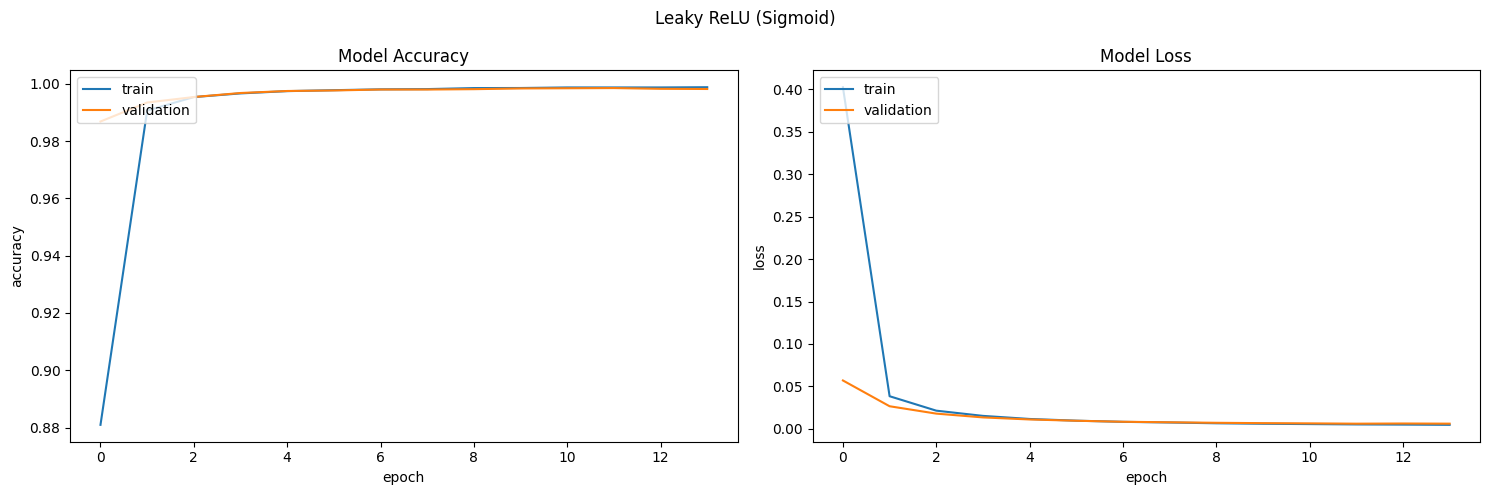

701/701 [==============================] - 0s 350us/step
Parametric ReLU (Sigmoid):
	Time to train: 24.0523s
	Time to test: 18.8911s


<Figure size 640x480 with 0 Axes>

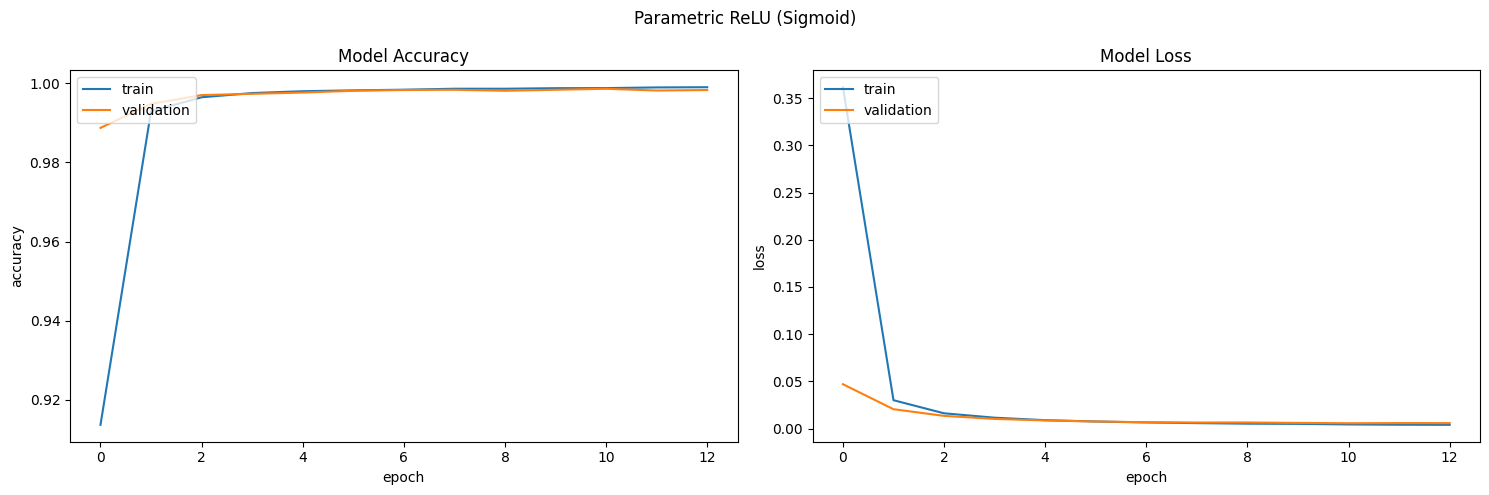

701/701 [==============================] - 0s 343us/step
ELU (Sigmoid):
	Time to train: 23.3538s
	Time to test: 18.7479s


<Figure size 640x480 with 0 Axes>

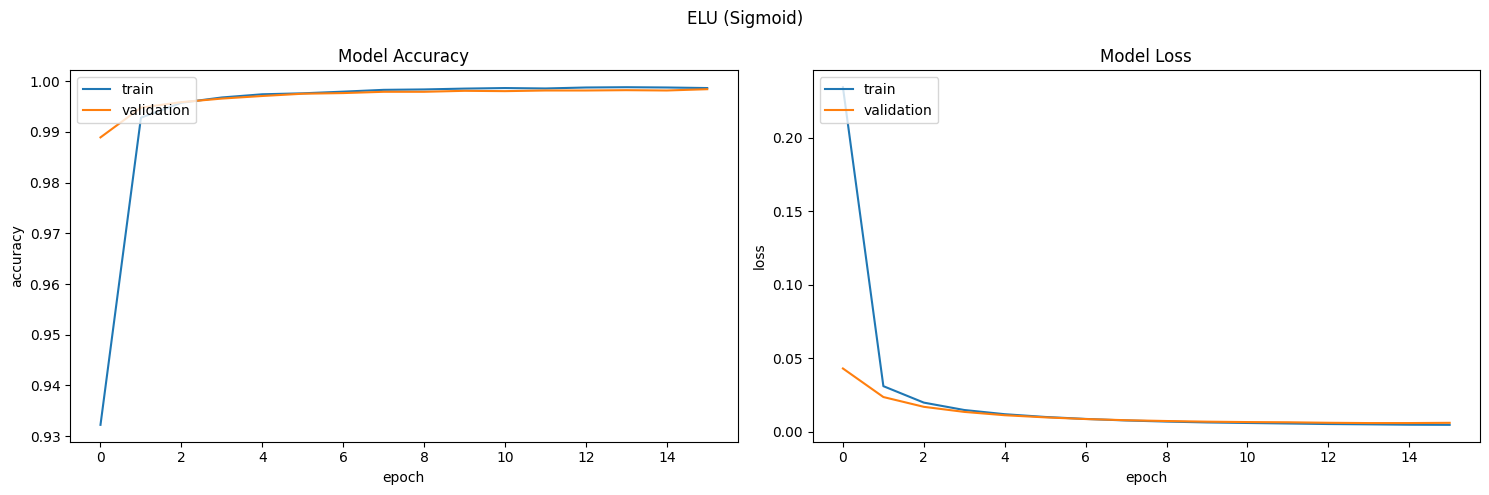

701/701 [==============================] - 0s 337us/step
GeLU (Sigmoid):
	Time to train: 23.9940s
	Time to test: 19.3063s


<Figure size 640x480 with 0 Axes>

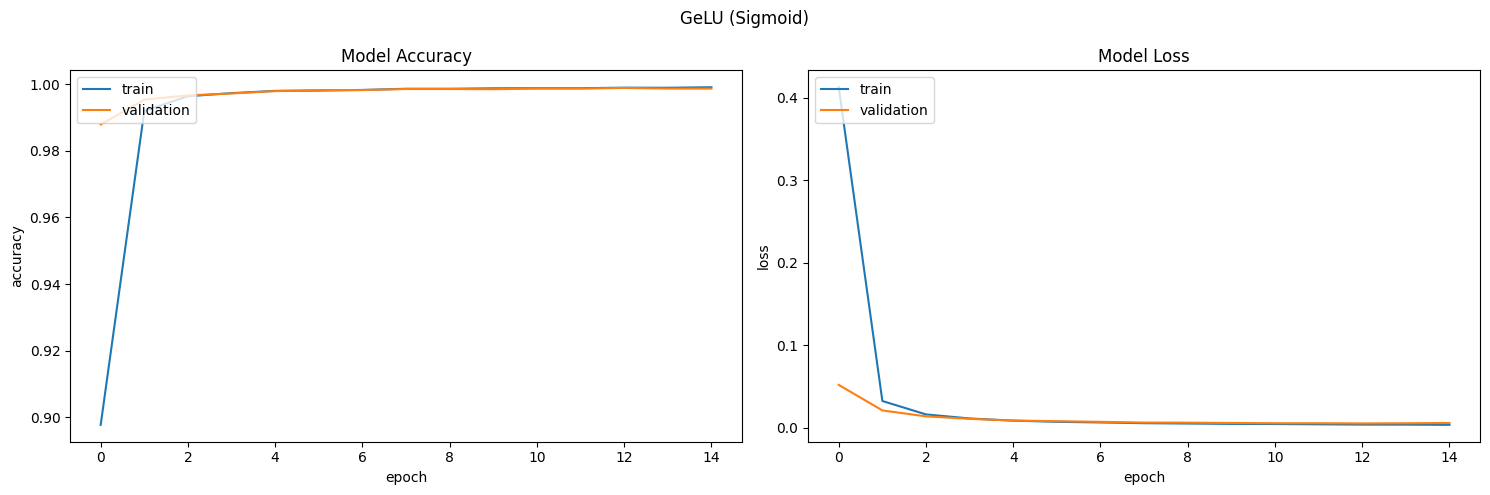

701/701 [==============================] - 0s 345us/step
Tanh (Sigmoid):
	Time to train: 23.9140s
	Time to test: 19.0304s


<Figure size 640x480 with 0 Axes>

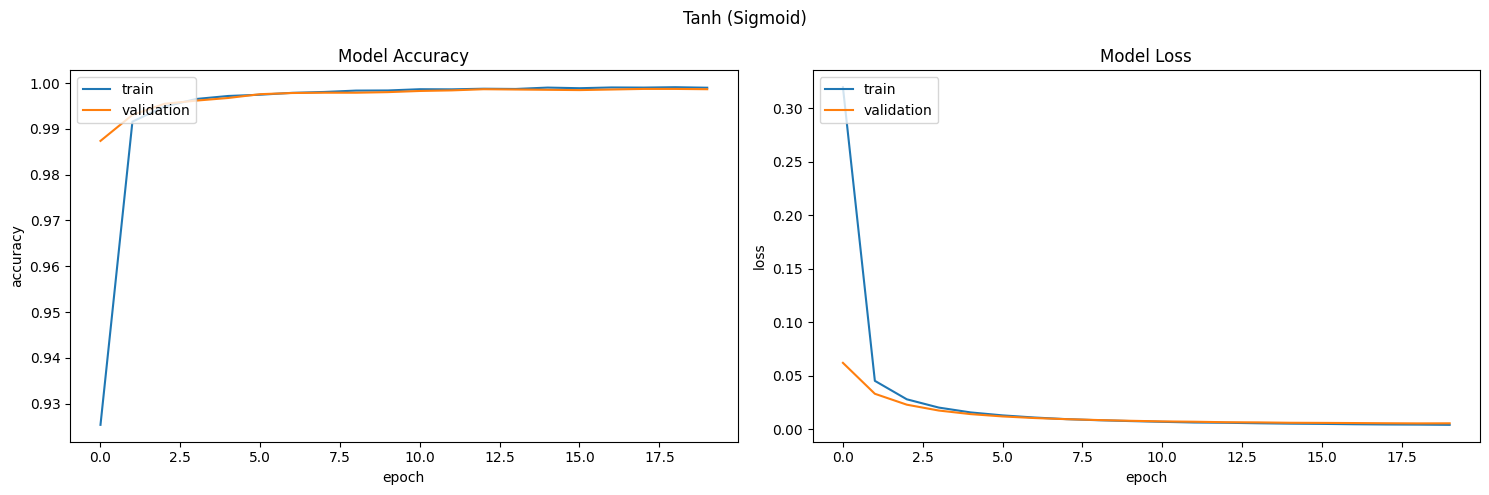

701/701 [==============================] - 0s 356us/step
Sigmoid (Sigmoid):
	Time to train: 23.9400s
	Time to test: 19.1129s


<Figure size 640x480 with 0 Axes>

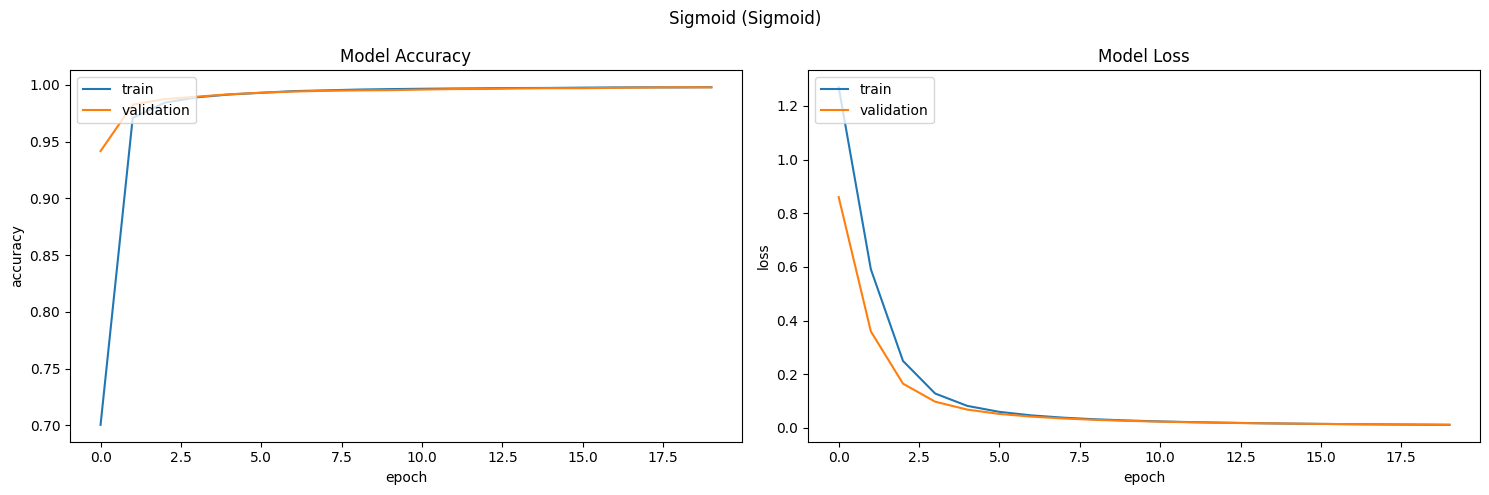

701/701 [==============================] - 0s 373us/step
Softmax (Sigmoid):
	Time to train: 23.9389s
	Time to test: 19.0178s


<Figure size 640x480 with 0 Axes>

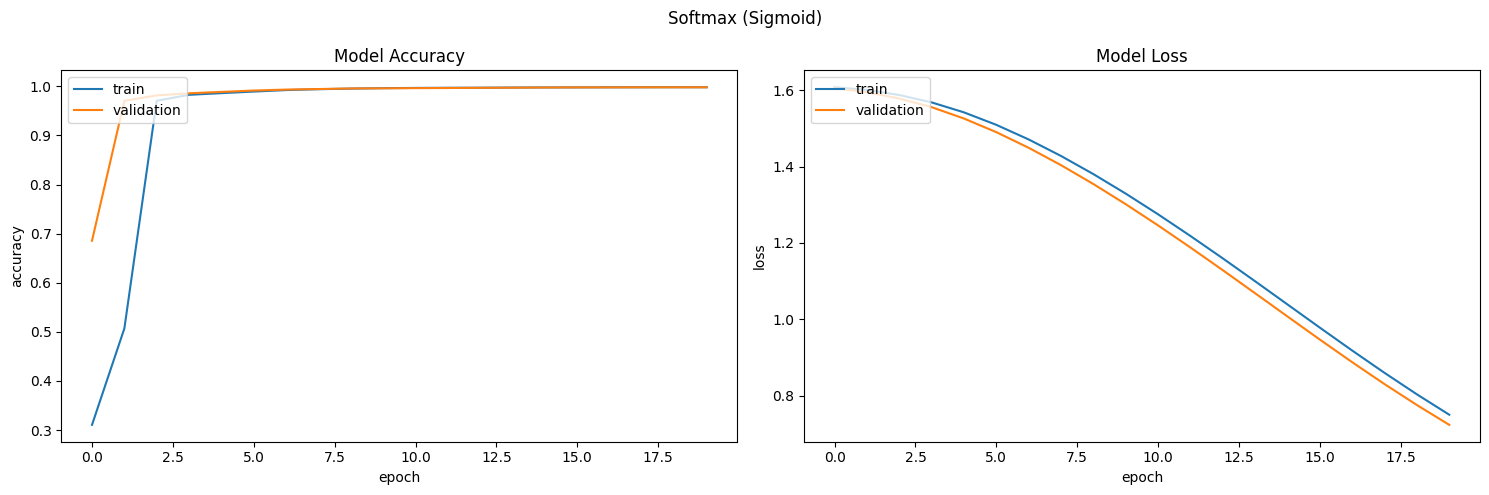

701/701 [==============================] - 0s 405us/step
Softplus (Sigmoid):
	Time to train: 23.9947s
	Time to test: 19.1088s


<Figure size 640x480 with 0 Axes>

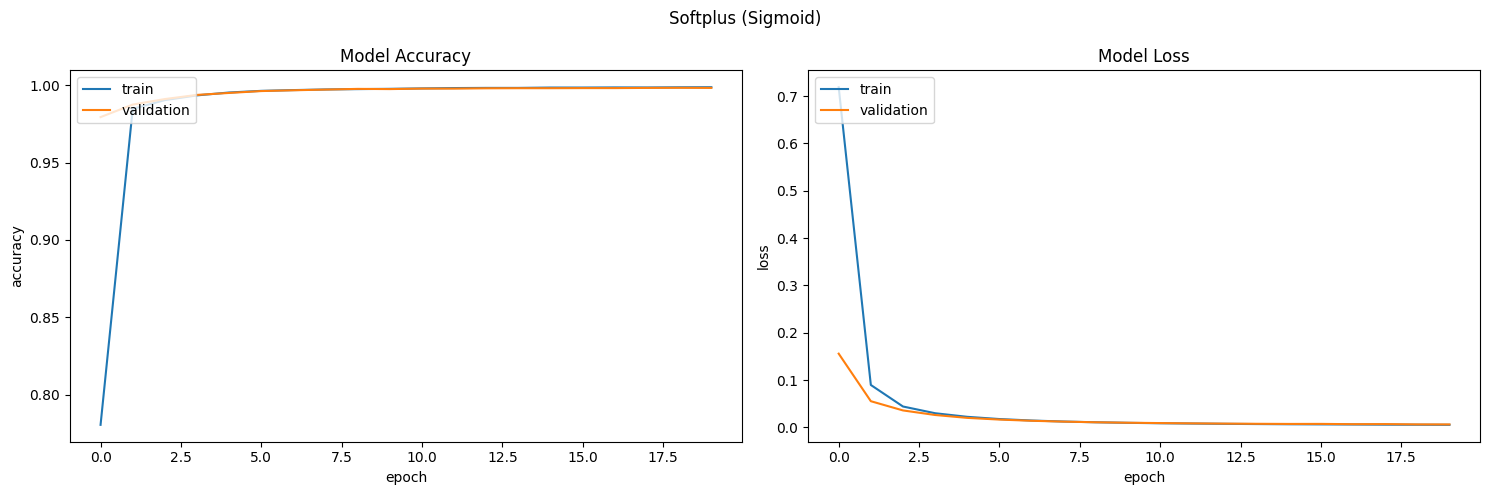

701/701 [==============================] - 0s 342us/step
Softsign (Sigmoid):
	Time to train: 23.7185s
	Time to test: 18.8480s


<Figure size 640x480 with 0 Axes>

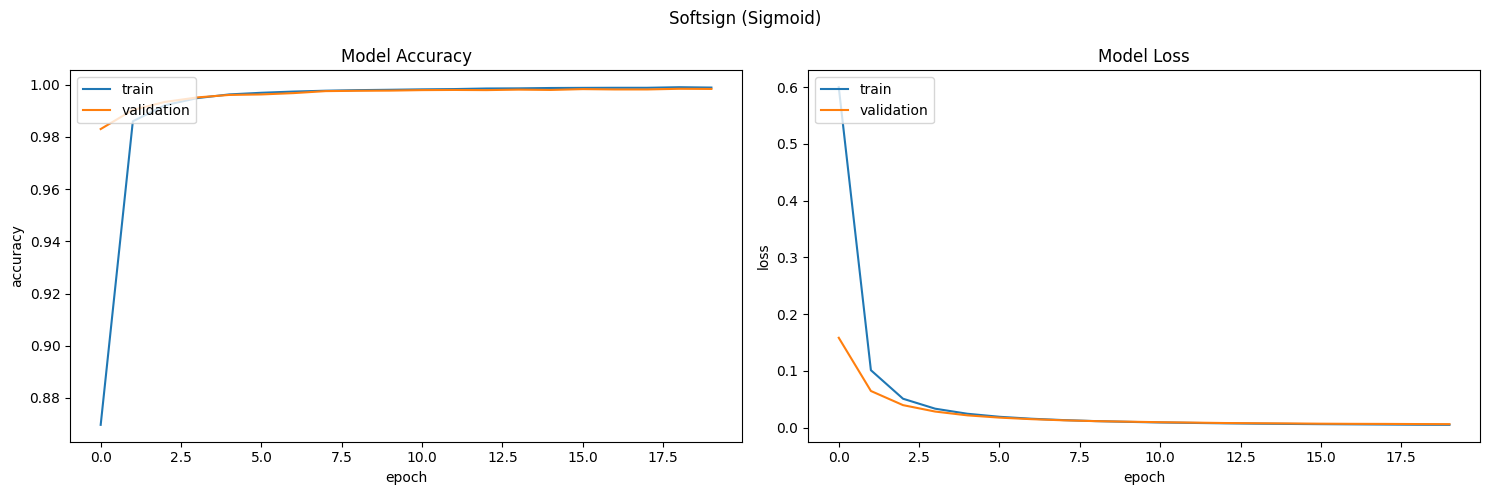

<Figure size 640x480 with 0 Axes>

In [139]:
#Test out all of thse activation functions, but with a sigmoid output function
for label, fun in activation_functions:
    network = build_activation_network(fun, 'sigmoid')
    history = perform_param_test(network, dfs_touse['Standard'], f"{label} (Sigmoid)", 1000, 20, callbacks=callbacks)
    plot_results(history, f"{label} (Sigmoid)")

Next, we will test the SELU activation, but with the standardized dataset (which is needed for this function), and the needed kernel initialization.

701/701 [==============================] - 0s 367us/step
SELU:
	Time to train: 23.1929s
	Time to test: 18.4627s


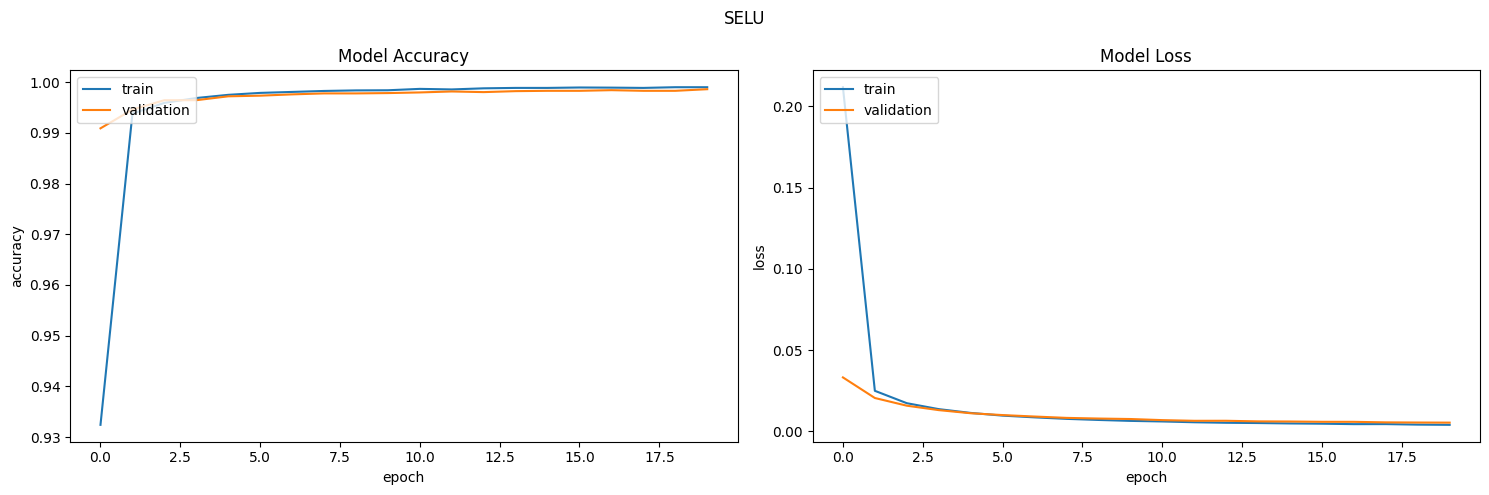

701/701 [==============================] - 0s 365us/step
SELU (Sigmoid):
	Time to train: 23.5244s
	Time to test: 18.3092s


<Figure size 640x480 with 0 Axes>

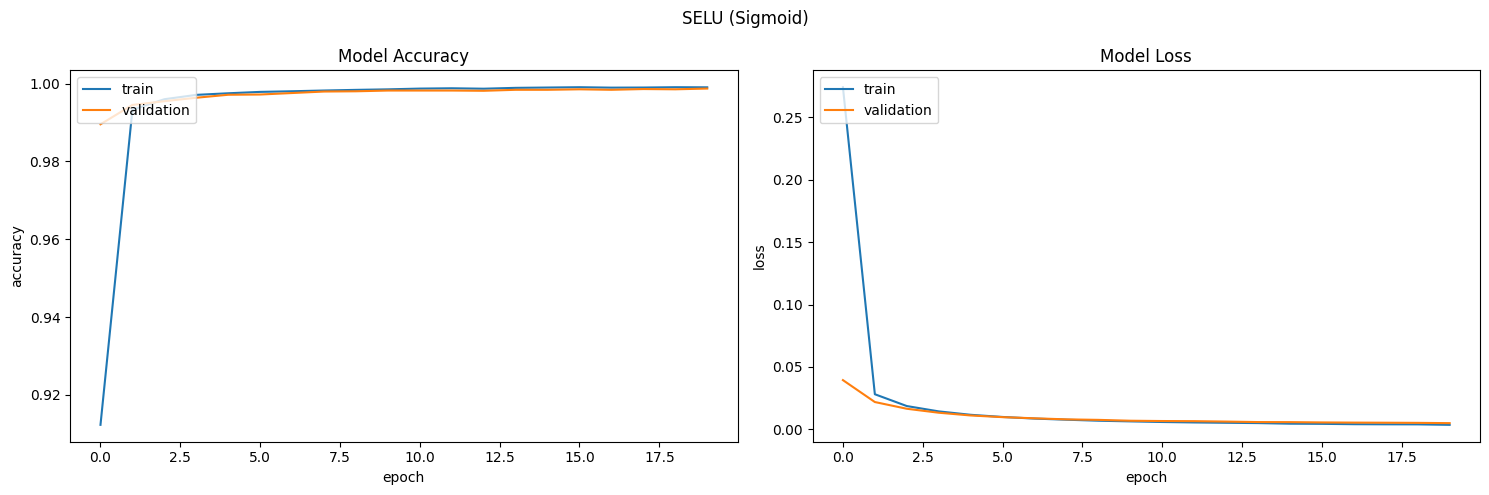

<Figure size 640x480 with 0 Axes>

In [141]:
#Test out the SELU activation function

def build_selu_network(output_activation):
    import keras
    from keras.models import Sequential
    from keras.layers import Dense, Dropout
    from keras import regularizers

    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation='selu', kernel_initializer='lecun_normal'))
    network.add(Dense(80, activation='selu', kernel_initializer='lecun_normal'))
    network.add(Dense(5, activation=output_activation))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer="adam", # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    
    return network

#Test with softmax
network = build_selu_network('softmax')
history = perform_param_test(network, dfs_touse['Standard'], "SELU", 1000, 20, callbacks=callbacks)
plot_results(history, "SELU")

#Test with sigmoid
network = build_selu_network('sigmoid')
history = perform_param_test(network, dfs_touse['Standard'], "SELU (Sigmoid)", 1000, 20, callbacks=callbacks)
plot_results(history, "SELU (Sigmoid)")

### Check out the results of all the activation functions

In [149]:
#Build results df
activation_df = pd.DataFrame.from_dict(param_results, orient='index')

#Get rid of all the columns except F1 scores
f1_activation_df = activation_df[['F1_Basmati','F1_Arborio','F1_Jasmine','F1_Ipsala','F1_Karacadag','F1_avg']]

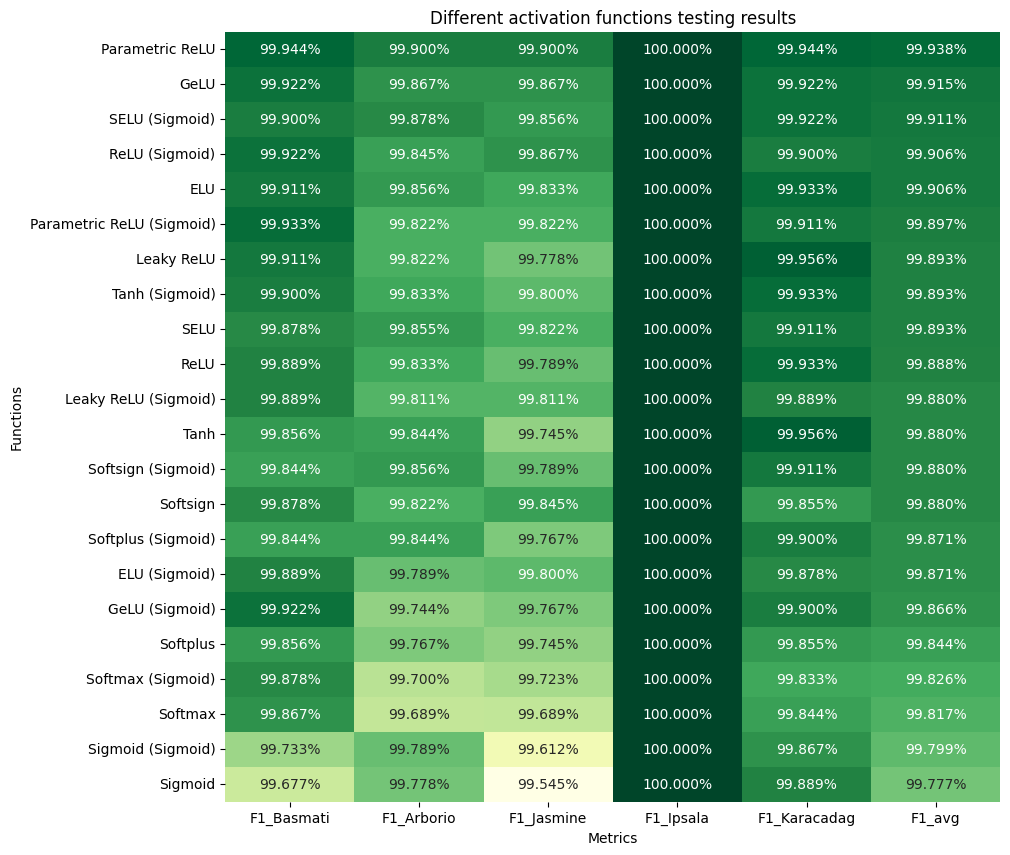

<Figure size 640x480 with 0 Axes>

In [150]:
#Heatmap
sorted_f1_activation_df = f1_activation_df.sort_values('F1_avg', axis=0, ascending=False)

plt.figure(figsize=(10,10))
sns.heatmap(sorted_f1_activation_df, annot=sorted_f1_activation_df, cmap="YlGn", cbar=False, fmt=".3%")
plt.title("Different activation functions testing results")
plt.xlabel("Metrics")
plt.ylabel("Functions")
plt.savefig(f"{figure_folder}activation-functions-results.png", bbox_inches = 'tight', dpi=400)
plt.show()
plt.close(fig)
plt.cla()
plt.clf()

It seems that using the **parameteric ReLU** activation function for our hidden layers, and using the **softmax** activation function for our ouput layer, provided the best results.

**Note:** Due to the unstable nature of some of these examples, epoch by epoch, it could be interesting to pick the best epoch by looking at the loss charts and repeat the testing with those, cross-validated this time for best results.

## Try different optimizers

Adam optimizer has proven to work very well, as is often the case with it. But, just for curiosity's sake, let's try out stochastic gradient descent.

In [56]:
def build_optimizer_network(optimizer):
    #Build neural network
    network = Sequential()
    network.add(Dense(80, input_dim=106, activation=PReLU()))
    network.add(Dense(80, activation=PReLU()))
    network.add(Dense(5, activation='softmax'))

    # Compile neural network
    network.compile(loss="categorical_crossentropy", # Cross-entropy
                    optimizer=optimizer, # Adam optization
                    metrics=["accuracy"]) # Accuracy performance metric
    
    return network

Adam:
	Time to train: 70.5477s
	Time to test: 59.0582s


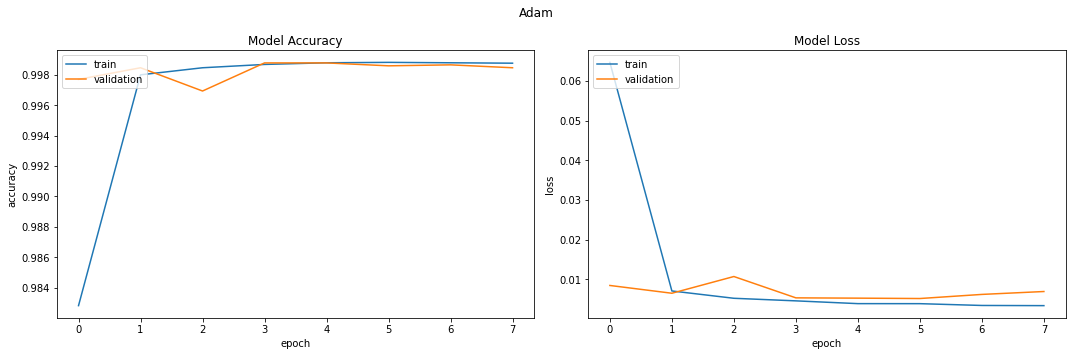

SGD:
	Time to train: 85.7139s
	Time to test: 60.4564s


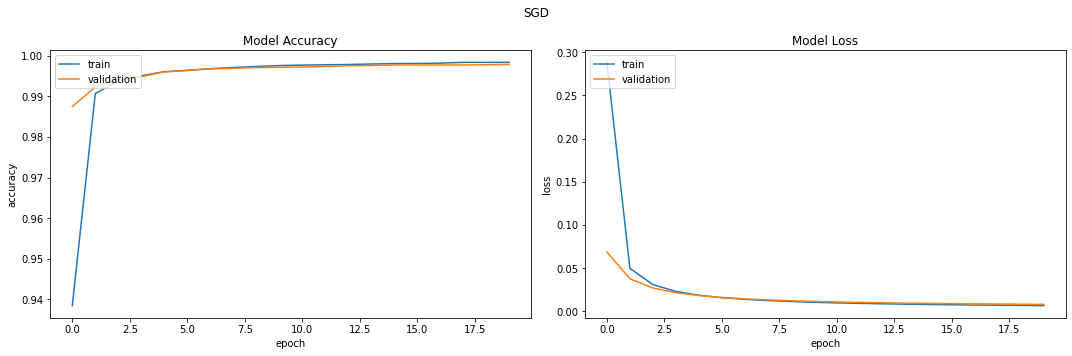

In [57]:
network_results = {}
history_results = {}

# Test adam optimizer
network = build_optimizer_network('adam')
history = perform_param_test(network, dfs_touse['Power'], "Adam", 100, 20, callbacks=callbacks)
plot_results(history, "Adam")

# Test SGD optimizer
network = build_optimizer_network('SGD')
history = perform_param_test(network, dfs_touse['Power'], "SGD", 100, 20, callbacks=callbacks)
plot_results(history, "SGD")

Three epochs seems like the optimal epoch count for Adam, so we will run it again.

Adam:
	Time to train: 70.3410s
	Time to test: 62.2708s


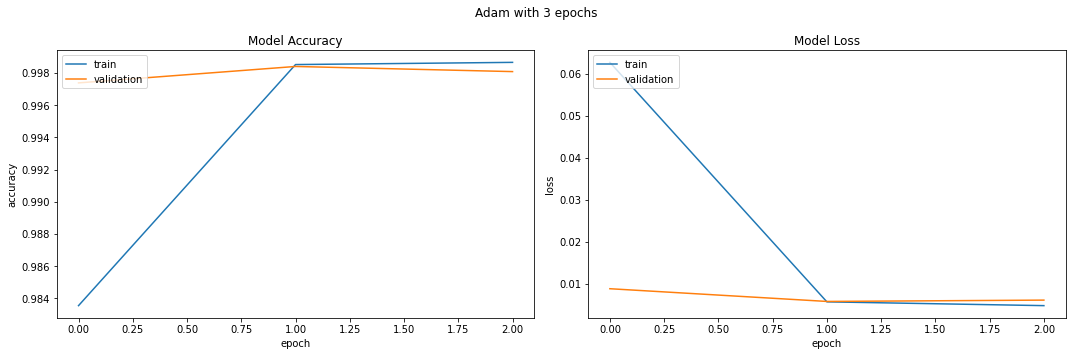

In [70]:
# Test adam optimizer with 3 epochs
network = build_optimizer_network('adam')
history = perform_param_test(network, dfs_touse['Power'], "Adam", 100, 3)
plot_results(history, "Adam with 3 epochs")

In [71]:
#Build results df
optimizer_df = pd.DataFrame.from_dict(network_results, orient='index')

Text(159.0, 0.5, 'Optimizers')

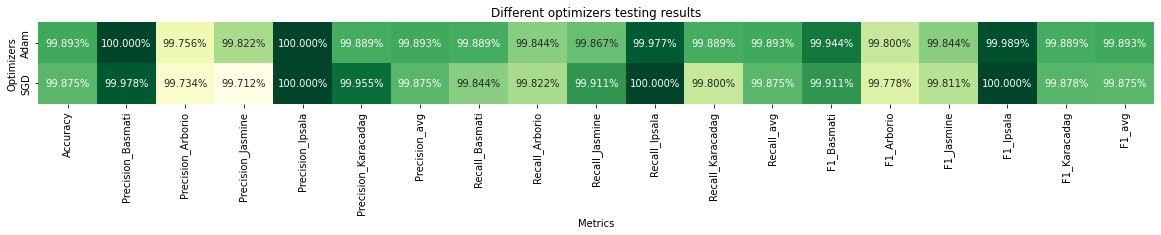

In [72]:
#Heatmap
plt.figure(figsize=(20,1.5))
sns.heatmap(optimizer_df, annot=optimizer_df, cmap="YlGn", cbar=False, fmt=".3%")
plt.title("Different optimizers testing results")
plt.xlabel("Metrics")
plt.ylabel("Optimizers")

The results are close, but it seems the **Adam** optimizer gives us the best results overall. To make sure, we will perform cross validation testing for both.

## Perform K-Fold Cross Validation for final testing results

In [73]:
def build_adam_network():
    return build_optimizer_network('adam')

def build_sgd_network():
    return build_optimizer_network('SGD')

In [75]:
final_results = {}

final_results['Adam'] = cv_test_network(build_adam_network, dfs_touse['Power'], reverse_target_column_dict, 'Adam', 100, 3)

Adam (fold number 0) - time to train: 88.6853s
Adam (fold number 1) - time to train: 90.1723s
Adam (fold number 2) - time to train: 95.0040s
Adam (fold number 3) - time to train: 97.6513s
Adam (fold number 4) - time to train: 92.7093s
Adam (fold number 5) - time to train: 90.2862s
Adam (fold number 6) - time to train: 93.8598s
Adam (fold number 7) - time to train: 88.9427s
Adam (fold number 8) - time to train: 94.6652s
Adam (fold number 9) - time to train: 92.4010s


In [76]:
final_results['SGD'] = cv_test_network(build_sgd_network, dfs_touse['Power'], reverse_target_column_dict, 'SGD', 100, 16)

SGD (fold number 0) - time to train: 105.1300s
SGD (fold number 1) - time to train: 113.3481s
SGD (fold number 2) - time to train: 114.9013s
SGD (fold number 3) - time to train: 114.2779s
SGD (fold number 4) - time to train: 115.7527s
SGD (fold number 5) - time to train: 115.5295s
SGD (fold number 6) - time to train: 119.6971s
SGD (fold number 7) - time to train: 122.7420s
SGD (fold number 8) - time to train: 121.0150s
SGD (fold number 9) - time to train: 110.9245s


In [77]:
#Build results df
final_testing_df = pd.DataFrame.from_dict(final_results, orient='index')

Text(159.0, 0.5, 'Optimizers')

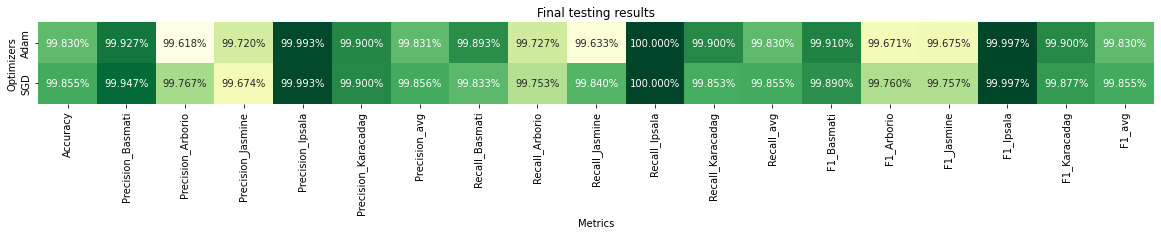

In [78]:
#Heatmap
plt.figure(figsize=(20,1.5))
sns.heatmap(final_testing_df, annot=final_testing_df, cmap="YlGn", cbar=False, fmt=".3%")
plt.title("Final testing results")
plt.xlabel("Metrics")
plt.ylabel("Optimizers")